In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width: 98% !important }</style>'))

In [2]:
import joblib
from datetime import timedelta
import pandas as pd
from sklearn.preprocessing import normalize
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

pd.set_option('display.max_rows', 10000)

In [3]:
from utilities import *

In [4]:
ble = read_ble('../Data/ble.csv')
pin = read_pin('../Data/pin.csv')
test_pin = read_pin('../Data/testPin.csv')

In [5]:
def read_sequence_rssi(filename):
    rssi = pd.read_csv(filename)
    rssi = rssi.pivot_table(columns="scanner", values="rssi", index="time")
    rssi.rename_axis(None, axis=1, inplace=True)
    rssi.index = pd.to_datetime(rssi.index)
    rssi = rssi.groupby(pd.Grouper(freq='100ms')).mean()
    return rssi

def read_sequence_loc(filename):
    loc = pd.read_csv(filename)
    loc['time'] = pd.to_datetime(loc['time'])
    loc.set_index('time', inplace=True)
    loc = loc.groupby(pd.Grouper(freq='100ms')).mean()
    return loc

In [6]:
rssi = read_sequence_rssi('../Data/sequenceRssi5.csv')
loc = read_sequence_loc('../Data/sequenceLoc5.csv')

In [7]:
loc.isna().sum()

X    1946
Y    1946
dtype: int64

In [8]:
def transform(loc, inplace=False):
    if inplace:
        loc['X'] = 24.187023 + loc['X']
        loc['Y'] = 12.252072 - loc['Y']
    else:
        transformed = pd.DataFrame()
        transformed['X'] = 24.187023 + loc['X']
        transformed['Y'] = 12.252072 - loc['Y']
        return transformed

In [9]:
transform(loc, inplace=True)

In [10]:
loc = loc.interpolate(method='linear')
loc = loc[loc['X'] >= 11.5]

In [11]:
def show_loc(ori_loc):
    img =  mpimg.imread('../Map/main.png')
    plt.figure(figsize=(40,40))
    plt.imshow(img)
    plt.scatter(ori_loc['X'] * 44, ori_loc['Y'] * 44, alpha=0.2)
    plt.show()

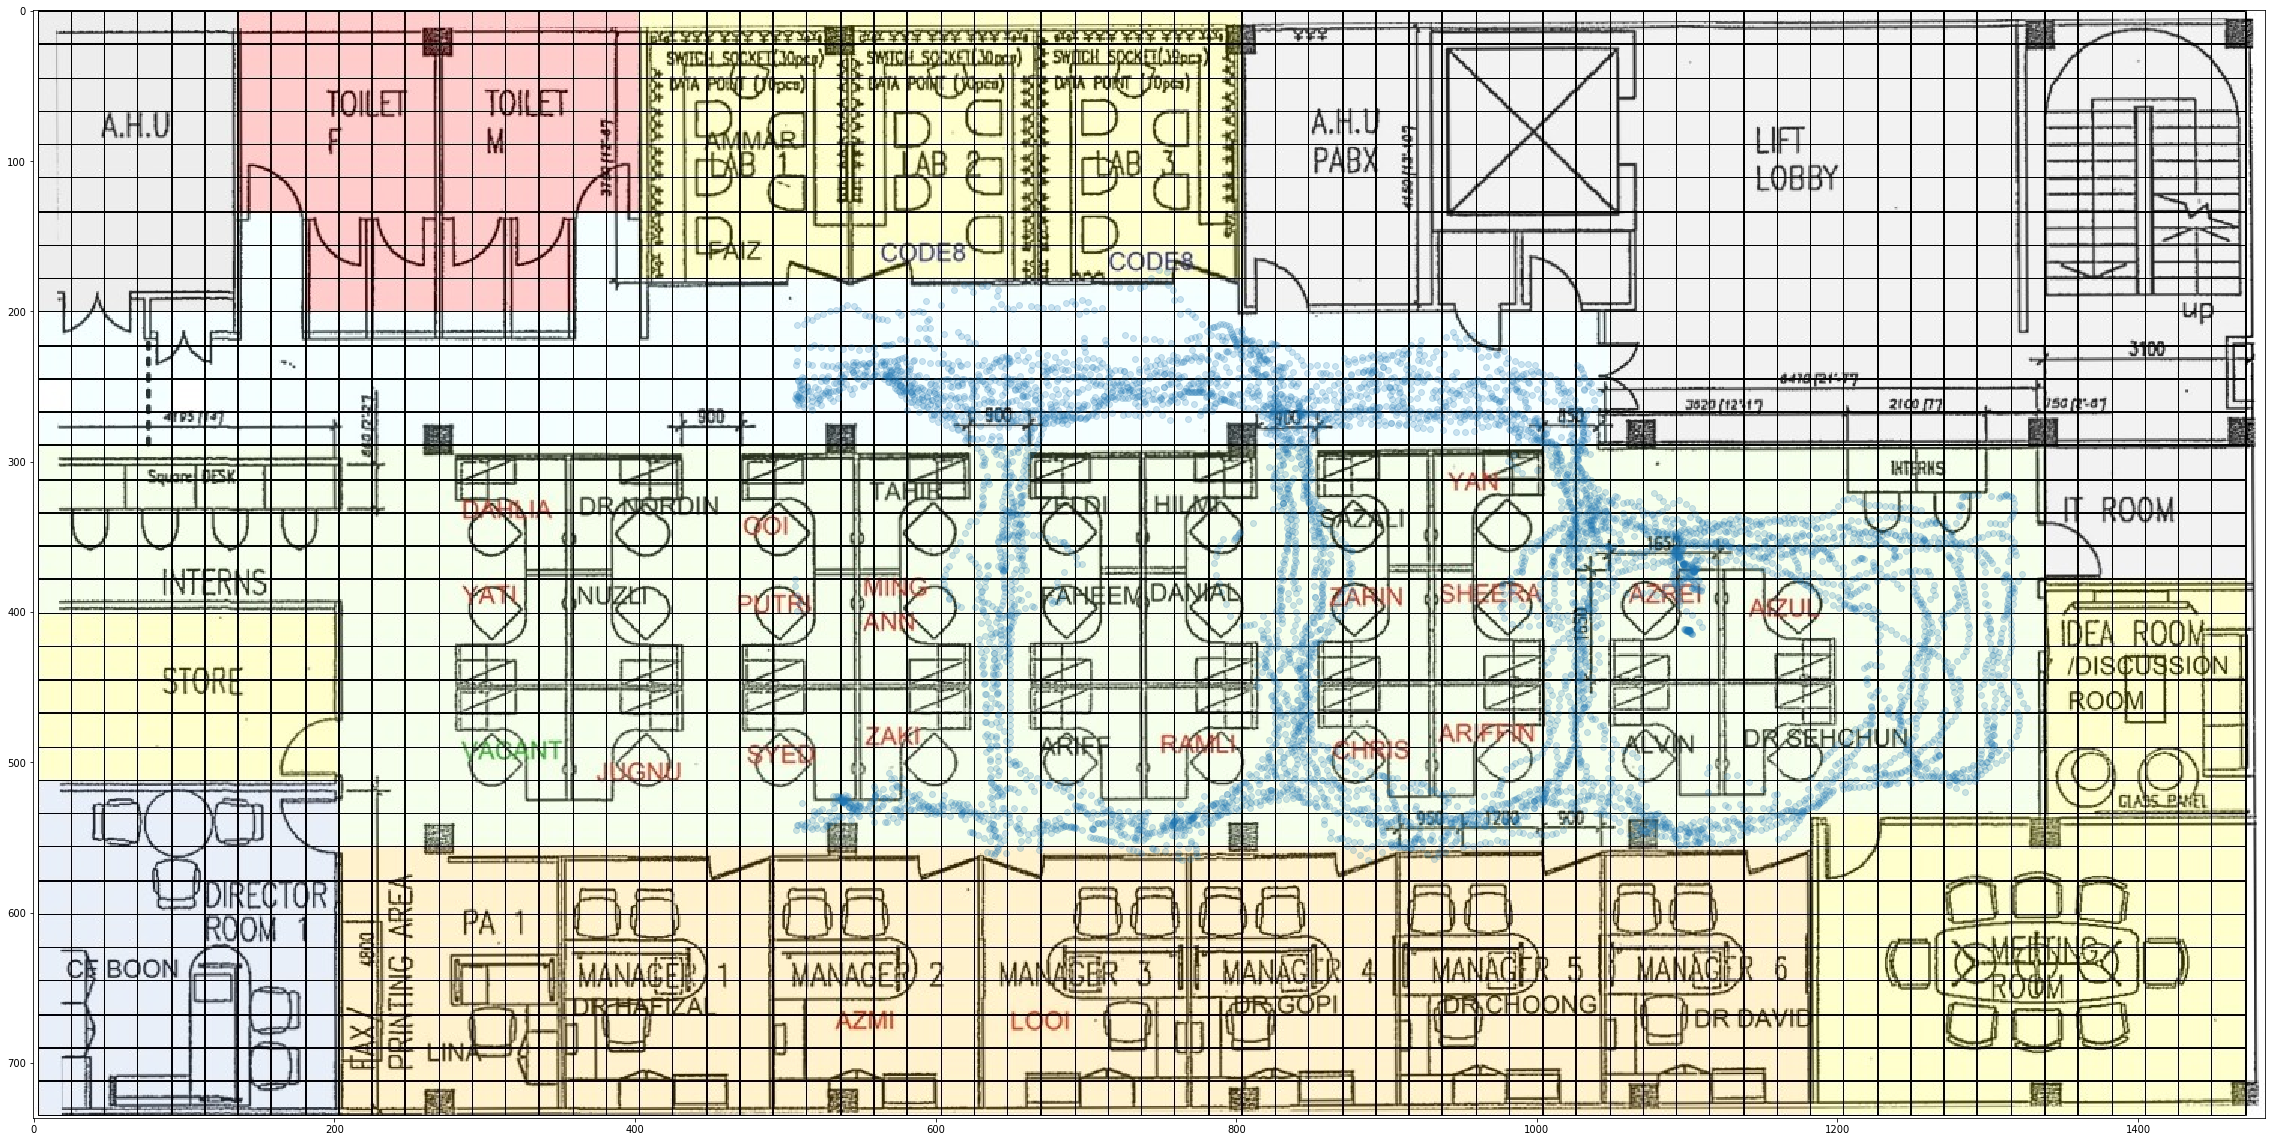

In [12]:
show_loc(loc)

In [13]:
data = rssi.join(loc, how='inner')
data.shape

(6424, 19)

In [14]:
data.isna().sum()

C400A2E19293    5969
CD4533FFC0E1    5747
D2B6503554D7    5875
DB8B36A69C56    5792
DD697EA75B68    5885
DF231643E227    5549
E13B805C6CB0    5605
E43355CA8B96    6054
E6D9D20DD197    5260
E8FD0B453DC4    6126
E96AF2C858BA    5379
EC72840D9AD3    5708
F1307ECB3B90    5667
F1EDAF28E08A    5956
F69A86823B96    5735
FB2EE01C18CE    5833
FDAE5980F28C    5990
X                  0
Y                  0
dtype: int64

In [15]:
def read_stationary_data(filename):
    data = read_data(filename)
    data = data.set_index('time').groupby([pd.Grouper('location'), pd.Grouper(freq='100ms')]).mean()
    data = data.groupby('location').head(500)
    data = data.reset_index(0)
    data["X"] = data["location"].apply(lambda x: pin[x]["X"] if x[0] == 'V' else test_pin[x]["X"])
    data["Y"] = data["location"].apply(lambda x: pin[x]["Y"] if x[0] == 'V' else test_pin[x]["Y"])
    return data[scanners + ['X', 'Y']]

In [16]:
stationary_data = read_stationary_data('../Data/rssi_2.csv')

All beacons: ['0117C55D14E4']
Selecting all


In [17]:
data = pd.concat([stationary_data, data], axis=0, sort=True)
data.sort_index(inplace=True)

In [18]:
data.describe()

C400A2E19293  CD4533FFC0E1  D2B6503554D7  DB8B36A69C56  DD697EA75B68  \
count   1653.000000   1869.000000   1575.000000   2223.000000   1789.000000   
mean     -73.571335    -73.267879    -75.726931    -72.756860    -71.925377   
std        8.299588      7.216015      7.231130      8.612631      6.842356   
min      -96.000000    -98.000000    -98.000000    -98.000000    -96.000000   
25%      -79.000000    -77.000000    -80.000000    -79.000000    -77.000000   
50%      -73.000000    -72.000000    -75.000000    -72.000000    -71.000000   
75%      -68.000000    -68.000000    -71.000000    -65.000000    -66.000000   
max      -48.000000    -52.000000    -53.000000    -57.000000    -52.000000   

       DF231643E227  E13B805C6CB0  E43355CA8B96  E6D9D20DD197  E8FD0B453DC4  \
count   2399.000000   2293.000000   1717.000000   3320.000000   1138.000000   
mean     -72.474364    -74.472663    -75.668414    -77.752937    -79.762742   
std        7.964743      8.391389      9.031453     10.723889      8.836960   
min      -97.000000    -98.000000    -98.000000    -98.000000    -98.000000   
25%      -77.500000    -80.500000    -82.000000    -87.000000    -87.000000   
50%      -71.000000    -75.000000    -76.000000    -78.000000    -80.000000   
75%      -66.000000    -69.000000    -69.000000    -70.000000    -72.000000   
max      -48.000000    -53.000000    -56.000000    -51.000000    -64.000000   

       E96AF2C858BA  EC72840D9AD3  F1307ECB3B90  F1EDAF28E08A  F69A86823B96  \
count   2698.000000   2008.000000   2606.000000   2027.000000   2260.000000   
mean     -75.490833    -72.238131    -68.774559    -78.478490    -74.340796   
std        9.577553      7.588351      7.788575      9.784124      8.277301   
min      -98.000000    -97.000000    -95.000000    -98.000000    -98.000000   
25%      -83.000000    -77.000000    -74.000000    -87.000000    -80.000000   
50%      -75.000000    -72.000000    -68.000000    -77.000000    -75.000000   
75%      -67.000000    -67.000000    -63.000000    -72.000000    -68.000000   
max      -49.000000    -51.000000    -48.000000    -58.000000    -51.000000   

       FB2EE01C18CE  FDAE5980F28C             X             Y  
count   1385.000000   1569.000000  16924.000000  16924.000000  
mean     -82.279663    -75.927926     18.360810      8.557077  
std        8.241296      8.403552      7.026914      2.677098  
min      -98.000000    -98.000000      5.180690      3.915325  
25%      -89.000000    -82.000000     14.063600      5.611869  
50%      -84.000000    -75.000000     18.712299      8.203950  
75%      -74.000000    -70.000000     23.244200     11.717700  
max      -64.000000    -56.000000     30.135649     12.843796

In [19]:
test_rssi = read_sequence_rssi('../Data/testSequenceRssi.csv')
test_loc = read_sequence_loc('../Data/testSequenceLoc.csv')

In [20]:
test_loc.isna().sum()

X    995
Y    995
dtype: int64

In [21]:
transform(test_loc, inplace=True)

In [22]:
test_loc = test_loc.interpolate(method='linear')
test_loc = test_loc[test_loc['X'] >= 11.5]

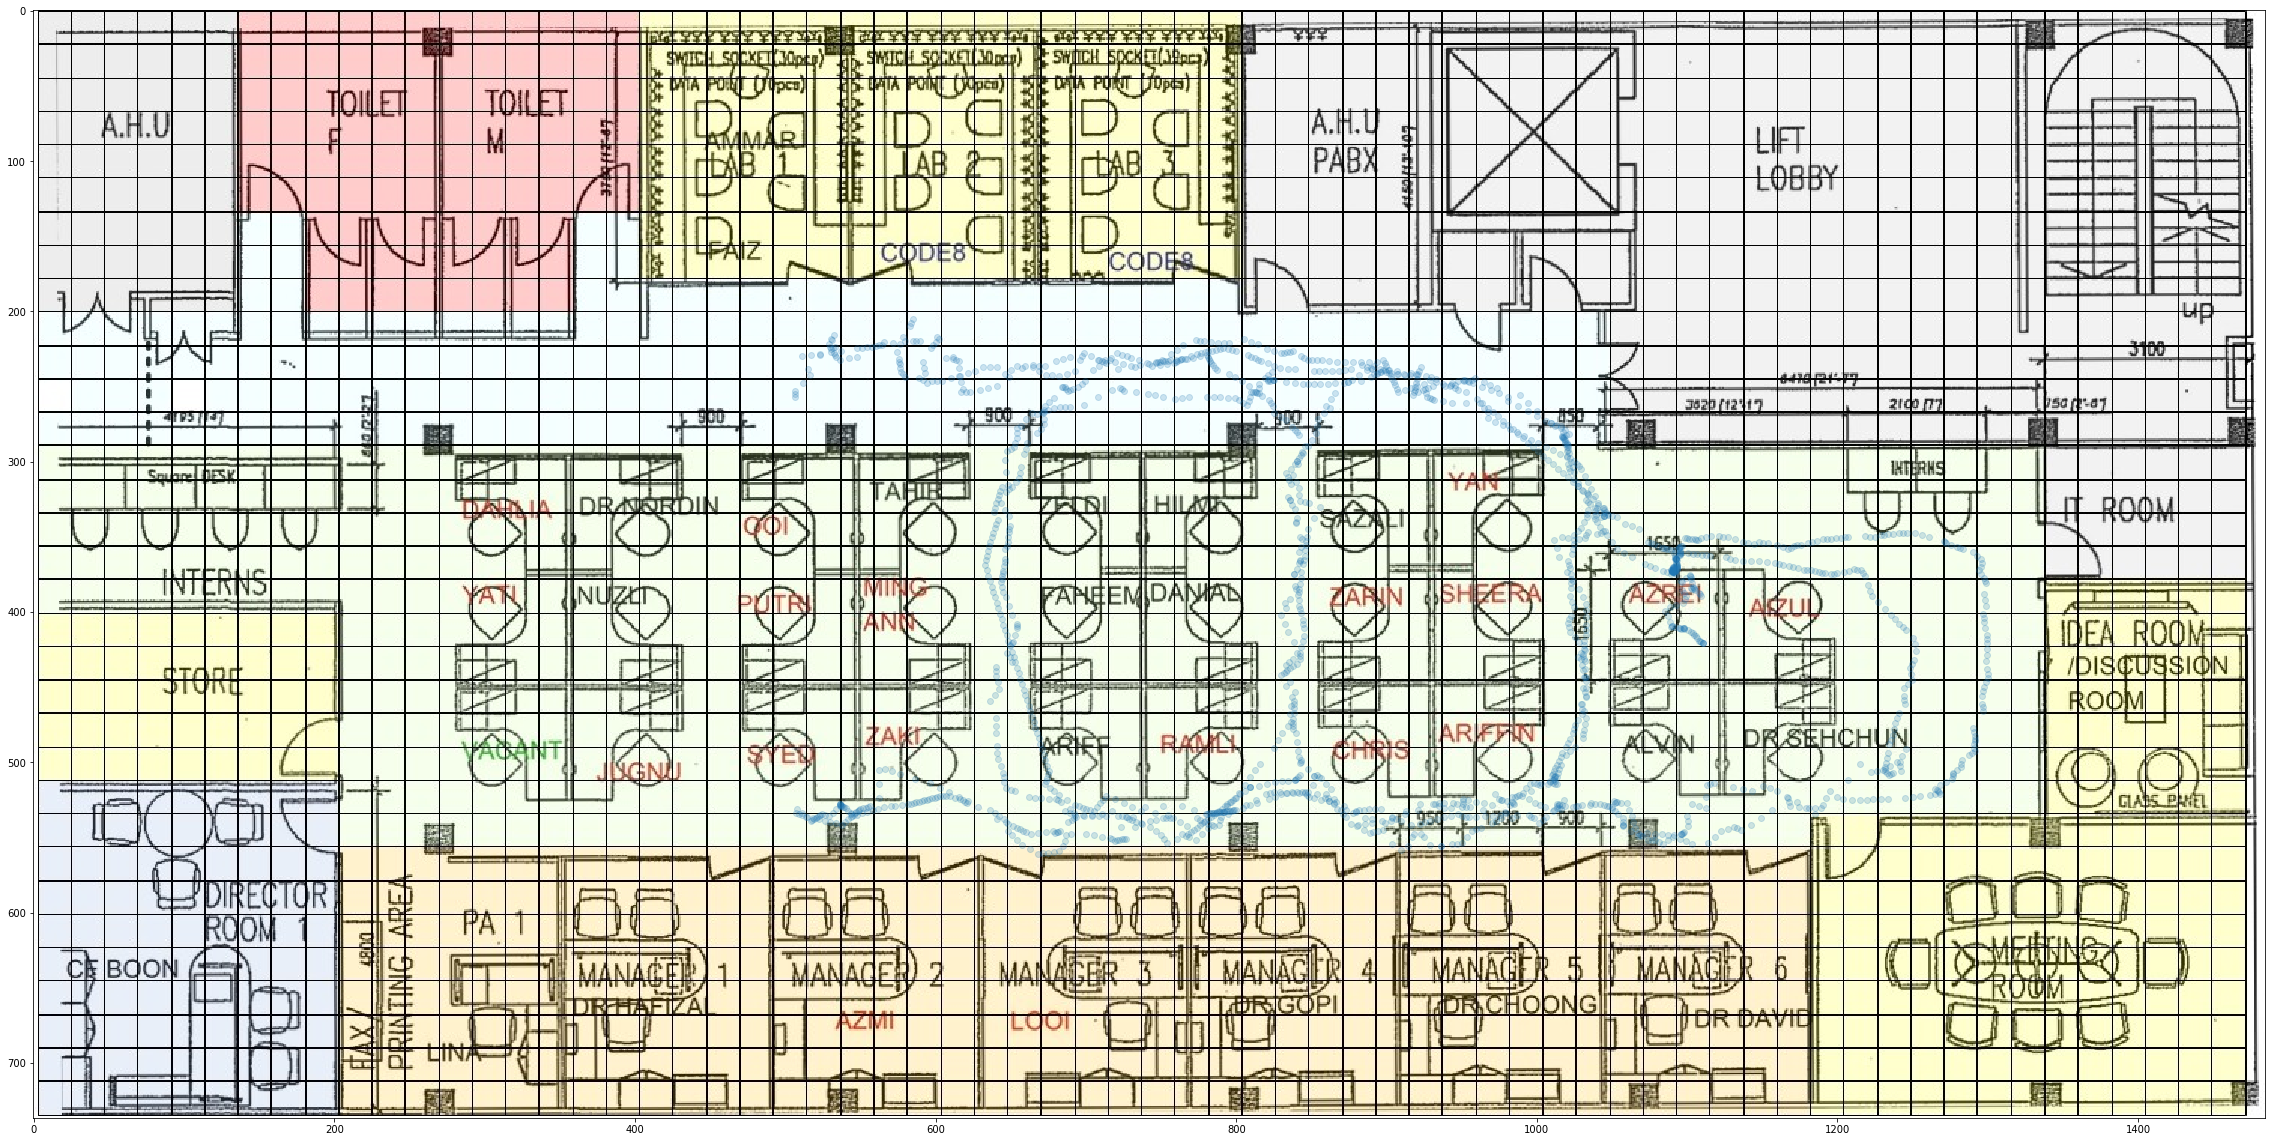

In [23]:
show_loc(test_loc)

In [24]:
test = test_rssi.join(test_loc, how='inner')
test.shape

(1791, 19)

In [25]:
test.isna().sum()

C400A2E19293    1644
CD4533FFC0E1    1590
D2B6503554D7    1615
DB8B36A69C56    1611
DD697EA75B68    1573
DF231643E227    1470
E13B805C6CB0    1430
E43355CA8B96    1642
E6D9D20DD197    1349
E8FD0B453DC4    1697
E96AF2C858BA    1423
EC72840D9AD3    1579
F1307ECB3B90    1528
F1EDAF28E08A    1595
F69A86823B96    1614
FB2EE01C18CE    1480
FDAE5980F28C    1659
X                  0
Y                  0
dtype: int64

In [26]:
stationary_test = read_stationary_data('../Data/testRssi.csv')

All beacons: ['0117C55D14E4']
Selecting all


In [27]:
test = pd.concat([stationary_test, test], axis=0, sort=True)
test.sort_index(inplace=True)

In [28]:
test.describe()

C400A2E19293  CD4533FFC0E1  D2B6503554D7  DB8B36A69C56  DD697EA75B68  \
count    646.000000    758.000000    629.000000    728.000000    718.000000   
mean     -73.443885    -75.865435    -75.709327    -76.285256    -71.798863   
std        9.976594      7.962382      7.991757      7.401690      7.935671   
min      -94.000000    -96.000000    -96.000000    -98.000000    -97.000000   
25%      -82.000000    -82.000000    -81.000000    -81.000000    -77.000000   
50%      -72.000000    -75.000000    -76.000000    -76.000000    -72.000000   
75%      -67.000000    -70.000000    -70.000000    -71.000000    -65.000000   
max      -49.000000    -54.000000    -53.000000    -53.000000    -48.000000   

       DF231643E227  E13B805C6CB0  E43355CA8B96  E6D9D20DD197  E8FD0B453DC4  \
count    874.000000    931.000000    704.000000   1050.000000    423.000000   
mean     -70.929825    -73.093716    -76.056818    -78.969841    -80.024429   
std        9.302609      8.230770      9.343045      8.662983      9.458074   
min      -97.000000    -98.000000    -98.000000    -97.000000    -98.000000   
25%      -77.000000    -79.000000    -84.000000    -86.000000    -88.000000   
50%      -70.250000    -71.000000    -75.000000    -80.000000    -80.000000   
75%      -65.500000    -67.000000    -67.000000    -71.125000    -74.000000   
max      -48.000000    -51.000000    -62.000000    -52.000000    -62.000000   

       E96AF2C858BA  EC72840D9AD3  F1307ECB3B90  F1EDAF28E08A  F69A86823B96  \
count    979.000000    750.000000    826.000000    784.000000    646.000000   
mean     -76.228635    -72.976889    -71.046610    -79.631059    -78.040970   
std        8.971861      8.609439      8.076408     10.739802      8.486108   
min      -97.000000    -94.000000    -96.000000    -98.000000    -98.000000   
25%      -83.000000    -79.000000    -76.000000    -89.000000    -86.000000   
50%      -75.000000    -73.000000    -70.000000    -82.000000    -77.000000   
75%      -69.000000    -68.000000    -66.000000    -69.000000    -72.000000   
max      -51.000000    -51.000000    -48.000000    -63.000000    -53.000000   

       FB2EE01C18CE  FDAE5980F28C            X            Y  
count    683.000000    623.000000  5678.000000  5678.000000  
mean     -82.648487    -76.863296    17.933026     9.063283  
std        7.104395      6.947250     6.836720     2.546131  
min      -97.000000    -98.000000     5.626103     4.554205  
25%      -89.000000    -81.000000    12.717952     6.570950  
50%      -83.000000    -76.000000    18.790348     9.659024  
75%      -77.000000    -71.000000    23.355726    11.912283  
max      -63.000000    -55.000000    29.934250    12.750413

In [29]:
def impute(data):
    data.update(data.rolling('5s').mean())
    data.ffill(inplace=True)

In [30]:
def linear_impute(data):
    for s in scanners:
        dx = data['X'] - ble[s]['X']
        dy = data['Y'] - ble[s]['Y']
        d = np.sqrt(np.square(dy) + np.square(dx))
        reg = joblib.load('../Models/linear_distance_models_2/{}.joblib'.format(s))
        ss = pd.Series(reg.predict(d.values.reshape((-1, 1))))
        ss.index = data.index
        data[s].fillna(ss, inplace=True)

In [31]:
impute(data)
linear_impute(data)
data[scanners] = normalize(data[scanners] + 100)

In [32]:
data

C400A2E19293  CD4533FFC0E1  D2B6503554D7  \
time                                                                
2020-01-09 07:53:05.300      0.114380      0.256843      0.197500   
2020-01-09 07:53:05.400      0.134534      0.256189      0.196997   
2020-01-09 07:53:05.800      0.131561      0.250529      0.192644   
2020-01-09 07:53:05.900      0.132161      0.251671      0.193522   
2020-01-09 07:53:06.000      0.130690      0.248871      0.191369   
...                               ...           ...           ...   
2020-01-15 02:48:21.400      0.145406      0.301997      0.251664   
2020-01-15 02:48:21.500      0.146185      0.303615      0.253013   
2020-01-15 02:48:21.600      0.147422      0.304767      0.245704   
2020-01-15 02:48:21.700      0.146662      0.303195      0.244437   
2020-01-15 02:48:21.800      0.146603      0.303073      0.228362   

                         DB8B36A69C56  DD697EA75B68  DF231643E227  \
time                                                                
2020-01-09 07:53:05.300      0.175882      0.214777      0.339140   
2020-01-09 07:53:05.400      0.175435      0.214231      0.338276   
2020-01-09 07:53:05.800      0.171558      0.209497      0.330802   
2020-01-09 07:53:05.900      0.172340      0.252307      0.324395   
2020-01-09 07:53:06.000      0.170423      0.249500      0.320785   
...                               ...           ...           ...   
2020-01-15 02:48:21.400      0.215872      0.212517      0.393715   
2020-01-15 02:48:21.500      0.217029      0.213655      0.381081   
2020-01-15 02:48:21.600      0.218865      0.215463      0.367138   
2020-01-15 02:48:21.700      0.217737      0.242556      0.365245   
2020-01-15 02:48:21.800      0.217648      0.242458      0.365097   

                         E13B805C6CB0  E43355CA8B96  E6D9D20DD197  \
time                                                                
2020-01-09 07:53:05.300      0.306538      0.109982      0.362961   
2020-01-09 07:53:05.400      0.305758      0.109702      0.362037   
2020-01-09 07:53:05.800      0.299003      0.107278      0.354038   
2020-01-09 07:53:05.900      0.252307      0.072088      0.355651   
2020-01-09 07:53:06.000      0.269301      0.071286      0.351694   
...                               ...           ...           ...   
2020-01-15 02:48:21.400      0.298801      0.145406      0.281864   
2020-01-15 02:48:21.500      0.300804      0.146185      0.283374   
2020-01-15 02:48:21.600      0.303350      0.147422      0.285566   
2020-01-15 02:48:21.700      0.301785      0.146662      0.285803   
2020-01-15 02:48:21.800      0.301663      0.146603      0.285687   

                         E8FD0B453DC4  E96AF2C858BA  EC72840D9AD3  \
time                                                                
2020-01-09 07:53:05.300      0.027549      0.404631      0.222984   
2020-01-09 07:53:05.400      0.027479      0.403601      0.222417   
2020-01-09 07:53:05.800      0.026872      0.394684      0.155481   
2020-01-09 07:53:05.900      0.026994      0.408497      0.156190   
2020-01-09 07:53:06.000      0.026694      0.399992      0.154452   
...                               ...           ...           ...   
2020-01-15 02:48:21.400      0.100666      0.297026      0.260053   
2020-01-15 02:48:21.500      0.101205      0.298617      0.261446   
2020-01-15 02:48:21.600      0.102062      0.301145      0.263659   
2020-01-15 02:48:21.700      0.101535      0.299592      0.262299   
2020-01-15 02:48:21.800      0.101494      0.302227      0.274678   

                         F1307ECB3B90  F1EDAF28E08A  F69A86823B96  \
time                                                                
2020-01-09 07:53:05.300      0.202231      0.016025      0.337102   
2020-01-09 07:53:05.400      0.201717      0.015984      0.336244   
2020-01-09 07:53:05.800      0.197260      0.015631      0.328815   
2020-01-09 07:53:05.900      0.198159      0.015702      0.330313   
2020-01-09 07:53:06

In [33]:
impute(test)
linear_impute(test)
test[scanners] = normalize(test[scanners] + 100)

In [34]:
test.describe()

C400A2E19293  CD4533FFC0E1  D2B6503554D7  DB8B36A69C56  DD697EA75B68  \
count   5678.000000   5678.000000   5678.000000   5678.000000   5678.000000   
mean       0.239800      0.250512      0.238453      0.233553      0.273147   
std        0.090385      0.066115      0.068453      0.065111      0.065466   
min        0.067921      0.057201      0.074300      0.075257      0.038500   
25%        0.157733      0.214738      0.198684      0.183777      0.238435   
50%        0.236783      0.252691      0.228841      0.231672      0.267504   
75%        0.304698      0.288366      0.274586      0.277230      0.324367   
max        0.459777      0.412806      0.408776      0.392098      0.423184   

       DF231643E227  E13B805C6CB0  E43355CA8B96  E6D9D20DD197  E8FD0B453DC4  \
count   5678.000000   5678.000000   5678.000000   5678.000000   5678.000000   
mean       0.279940      0.251135      0.205791      0.164262      0.166668   
std        0.101382      0.091069      0.092749      0.093219      0.092824   
min        0.034871      0.034582      0.024384      0.041090      0.018754   
25%        0.196464      0.188630      0.137631      0.091125      0.105852   
50%        0.274110      0.248158      0.191783      0.156105      0.137492   
75%        0.361403      0.327216      0.250087      0.214041      0.220199   
max        0.542102      0.422978      0.454747      0.413665      0.444402   

       E96AF2C858BA  EC72840D9AD3  F1307ECB3B90  F1EDAF28E08A  F69A86823B96  \
count   5678.000000   5678.000000   5678.000000   5678.000000   5678.000000   
mean       0.204955      0.266742      0.285442      0.144651      0.227312   
std        0.102539      0.062681      0.061926      0.113805      0.077695   
min        0.032424      0.112524      0.126072      0.007093      0.022725   
25%        0.122862      0.219092      0.244349      0.065716      0.165414   
50%        0.175384      0.259778      0.291077      0.108070      0.226086   
75%        0.281882      0.310782      0.328130      0.161785      0.294771   
max        0.447424      0.458778      0.425639      0.455271      0.394142   

       FB2EE01C18CE  FDAE5980F28C            X            Y  
count   5678.000000   5678.000000  5678.000000  5678.000000  
mean       0.146689      0.218649    17.928036     9.062710  
std        0.075927      0.073361     6.819643     2.518999  
min        0.042938      0.048546     5.626103     4.554205  
25%        0.082816      0.174818    12.717952     6.570950  
50%        0.122064      0.220591    18.790348     9.659024  
75%        0.195217      0.273283    23.355118    11.927284  
max        0.359173      0.414665    29.934250    12.339797

In [35]:
def create_window(dataset, win_size, start_index=0, end_index=None):
    data = []
    labels = []

    start_index = start_index + win_size
    if end_index is None:
        end_index = len(dataset)

    for i in range(start_index, end_index, win_size):
        indices = range(i-win_size, i)
        slices = dataset.iloc[indices]
        if slices.index.max() - slices.index.min() < timedelta(milliseconds=win_size * 300):
            data.append(slices[scanners].values)
            labels.append(slices[['X', 'Y']].values)
    return np.array(data), np.array(labels)

In [36]:
win_size = 10
X, y = create_window(data, win_size)

In [37]:
X.shape

(1680, 10, 17)

In [38]:
X_test, y_test = create_window(test, win_size)

In [39]:
msk = np.random.rand(len(X)) < 0.8
X_train, y_train = X[msk], y[msk]
X_validation, y_validation = X[~msk], y[~msk]

In [40]:
X_train.shape

(1352, 10, 17)

In [41]:
batch_size = 32
ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds = ds.batch(batch_size).repeat()

In [42]:
ds_validation = tf.data.Dataset.from_tensor_slices((X_validation, y_validation))
ds_validation = ds_validation.batch(batch_size)

In [43]:
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
ds_test = ds_test.batch(batch_size)

In [44]:
epochs = 50000

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_mse')
]

metrics = ['mae', 'mse']

inputs = tf.keras.Input(shape=(win_size, 17))
lstm_x = tf.keras.layers.LSTM(256, activation='relu', return_sequences=True)(inputs)
lstm_y = tf.keras.layers.LSTM(256, activation='relu', return_sequences=True)(inputs)

x = tf.keras.layers.Dense(128, activation='relu')(lstm_x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dense(1)(x)

y = tf.keras.layers.Dense(128, activation='relu')(lstm_y)
y = tf.keras.layers.Dense(64, activation='relu')(y)
y = tf.keras.layers.Dense(32, activation='relu')(y)
y = tf.keras.layers.Dense(16, activation='relu')(y)
y = tf.keras.layers.Dense(1)(y)

outputs = tf.keras.layers.Concatenate(axis=2)([x, y])

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(0.00001)
model.compile(optimizer=optimizer, loss='mse', metrics=metrics)

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 17)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 10, 256)      280576      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 10, 256)      280576      input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10, 128)      32896       lstm[0][0]                       
______________________________________________________________________________________________

In [46]:
history = model.fit(ds, epochs=epochs, steps_per_epoch=X_train.shape[0] // batch_size, validation_data=ds_validation, callbacks=callbacks)

Train for 42 steps, validate for 11 steps
Epoch 1/50000
42/42 [==============================] - 6s 155ms/step - loss: 232.7028 - mae: 13.4400 - mse: 232.7028 - val_loss: 237.3196 - val_mae: 13.5443 - val_mse: 236.2531
Epoch 2/50000
42/42 [==============================] - 1s 13ms/step - loss: 231.8404 - mae: 13.3821 - mse: 230.5306 - val_loss: 236.8926 - val_mae: 13.5307 - val_mse: 235.8282
Epoch 3/50000
42/42 [==============================] - 0s 12ms/step - loss: 233.6849 - mae: 13.4223 - mse: 232.4174 - val_loss: 236.4217 - val_mae: 13.5153 - val_mse: 235.3594
Epoch 4/50000
42/42 [==============================] - 1s 13ms/step - loss: 230.5724 - mae: 13.3402 - mse: 229.2603 - val_loss: 235.9089 - val_mae: 13.4987 - val_mse: 234.8489
Epoch 5/50000
42/42 [==============================] - 0s 12ms/step - loss: 232.9417 - mae: 13.4042 - mse: 231.6834 - val_loss: 235.3391 - val_mae: 13.4801 - val_mse: 234.2812
Epoch 6/50000
42/42 [==============================] - 1s 12ms/step - loss: 2

42/42 [==============================] - 0s 12ms/step - loss: 73.0678 - mae: 6.3151 - mse: 72.7196 - val_loss: 73.0811 - val_mae: 6.2671 - val_mse: 72.8315
Epoch 48/50000
42/42 [==============================] - 1s 12ms/step - loss: 71.8720 - mae: 6.2448 - mse: 71.5600 - val_loss: 70.9867 - val_mae: 6.1607 - val_mse: 70.7443
Epoch 49/50000
42/42 [==============================] - 1s 12ms/step - loss: 69.4419 - mae: 6.1169 - mse: 69.1351 - val_loss: 69.1607 - val_mae: 6.0639 - val_mse: 68.9239
Epoch 50/50000
42/42 [==============================] - 0s 12ms/step - loss: 67.3279 - mae: 6.0164 - mse: 67.0252 - val_loss: 67.5563 - val_mae: 5.9762 - val_mse: 67.3243
Epoch 51/50000
42/42 [==============================] - 1s 13ms/step - loss: 66.3498 - mae: 5.9554 - mse: 66.0668 - val_loss: 66.0801 - val_mae: 5.8940 - val_mse: 65.8529
Epoch 52/50000
42/42 [==============================] - 1s 13ms/step - loss: 64.7725 - mae: 5.8793 - mse: 64.4954 - val_loss: 64.7076 - val_mae: 5.8197 - val_ms

Epoch 95/50000
42/42 [==============================] - 0s 11ms/step - loss: 28.6448 - mae: 3.6431 - mse: 28.5673 - val_loss: 28.5284 - val_mae: 3.5989 - val_mse: 28.4585
Epoch 96/50000
42/42 [==============================] - 0s 11ms/step - loss: 28.5581 - mae: 3.6268 - mse: 28.4898 - val_loss: 28.0712 - val_mae: 3.5683 - val_mse: 28.0037
Epoch 97/50000
42/42 [==============================] - 0s 11ms/step - loss: 27.4718 - mae: 3.5646 - mse: 27.3947 - val_loss: 27.6336 - val_mae: 3.5391 - val_mse: 27.5685
Epoch 98/50000
42/42 [==============================] - 1s 13ms/step - loss: 27.5753 - mae: 3.5659 - mse: 27.5101 - val_loss: 27.2036 - val_mae: 3.5101 - val_mse: 27.1412
Epoch 99/50000
42/42 [==============================] - 1s 12ms/step - loss: 26.9358 - mae: 3.5319 - mse: 26.8691 - val_loss: 26.7845 - val_mae: 3.4817 - val_mse: 26.7249
Epoch 100/50000
42/42 [==============================] - 1s 12ms/step - loss: 26.7266 - mae: 3.5125 - mse: 26.6657 - val_loss: 26.3750 - val_mae:

Epoch 143/50000
42/42 [==============================] - 1s 12ms/step - loss: 14.7301 - mae: 2.5901 - mse: 14.7294 - val_loss: 14.4238 - val_mae: 2.5353 - val_mse: 14.4104
Epoch 144/50000
42/42 [==============================] - 1s 13ms/step - loss: 14.4639 - mae: 2.5711 - mse: 14.4625 - val_loss: 14.2366 - val_mae: 2.5175 - val_mse: 14.2252
Epoch 145/50000
42/42 [==============================] - 1s 13ms/step - loss: 14.3573 - mae: 2.5526 - mse: 14.3580 - val_loss: 14.0549 - val_mae: 2.5001 - val_mse: 14.0455
Epoch 146/50000
42/42 [==============================] - 1s 13ms/step - loss: 14.0222 - mae: 2.5325 - mse: 14.0209 - val_loss: 13.8795 - val_mae: 2.4835 - val_mse: 13.8723
Epoch 147/50000
42/42 [==============================] - 0s 11ms/step - loss: 13.8068 - mae: 2.5129 - mse: 13.8055 - val_loss: 13.7106 - val_mae: 2.4679 - val_mse: 13.7057
Epoch 148/50000
42/42 [==============================] - 0s 11ms/step - loss: 13.4932 - mae: 2.4874 - mse: 13.4901 - val_loss: 13.5475 - val

Epoch 191/50000
42/42 [==============================] - 0s 11ms/step - loss: 8.4331 - mae: 2.0222 - mse: 8.4516 - val_loss: 8.4325 - val_mae: 2.0006 - val_mse: 8.4441
Epoch 192/50000
42/42 [==============================] - 0s 11ms/step - loss: 8.4769 - mae: 2.0290 - mse: 8.4980 - val_loss: 8.3545 - val_mae: 1.9929 - val_mse: 8.3668
Epoch 193/50000
42/42 [==============================] - 0s 11ms/step - loss: 8.4860 - mae: 2.0281 - mse: 8.5090 - val_loss: 8.2800 - val_mae: 1.9860 - val_mse: 8.2930
Epoch 194/50000
42/42 [==============================] - 0s 11ms/step - loss: 8.2984 - mae: 2.0007 - mse: 8.3199 - val_loss: 8.2097 - val_mae: 1.9800 - val_mse: 8.2236
Epoch 195/50000
42/42 [==============================] - 0s 11ms/step - loss: 8.2415 - mae: 1.9952 - mse: 8.2637 - val_loss: 8.1389 - val_mae: 1.9742 - val_mse: 8.1536
Epoch 196/50000
42/42 [==============================] - 0s 11ms/step - loss: 8.2639 - mae: 2.0076 - mse: 8.2881 - val_loss: 8.0659 - val_mae: 1.9681 - val_mse:

Epoch 240/50000
42/42 [==============================] - 0s 11ms/step - loss: 5.7130 - mae: 1.7410 - mse: 5.7443 - val_loss: 5.5573 - val_mae: 1.6982 - val_mse: 5.5708
Epoch 241/50000
42/42 [==============================] - 0s 11ms/step - loss: 5.6321 - mae: 1.7278 - mse: 5.6629 - val_loss: 5.5156 - val_mae: 1.6937 - val_mse: 5.5292
Epoch 242/50000
42/42 [==============================] - 0s 11ms/step - loss: 5.4867 - mae: 1.6959 - mse: 5.5158 - val_loss: 5.4742 - val_mae: 1.6894 - val_mse: 5.4879
Epoch 243/50000
42/42 [==============================] - 0s 11ms/step - loss: 5.3873 - mae: 1.6853 - mse: 5.4155 - val_loss: 5.4319 - val_mae: 1.6855 - val_mse: 5.4457
Epoch 244/50000
42/42 [==============================] - 0s 11ms/step - loss: 5.4597 - mae: 1.7038 - mse: 5.4900 - val_loss: 5.3891 - val_mae: 1.6814 - val_mse: 5.4029
Epoch 245/50000
42/42 [==============================] - 0s 11ms/step - loss: 5.3542 - mae: 1.6882 - mse: 5.3835 - val_loss: 5.3459 - val_mae: 1.6770 - val_mse:

Epoch 289/50000
42/42 [==============================] - 0s 11ms/step - loss: 3.9861 - mae: 1.5163 - mse: 4.0177 - val_loss: 4.0041 - val_mae: 1.5101 - val_mse: 4.0146
Epoch 290/50000
42/42 [==============================] - 0s 11ms/step - loss: 4.0481 - mae: 1.5270 - mse: 4.0812 - val_loss: 3.9768 - val_mae: 1.5065 - val_mse: 3.9867
Epoch 291/50000
42/42 [==============================] - 0s 11ms/step - loss: 4.0576 - mae: 1.5317 - mse: 4.0912 - val_loss: 3.9501 - val_mae: 1.5027 - val_mse: 3.9593
Epoch 292/50000
42/42 [==============================] - 0s 11ms/step - loss: 4.0436 - mae: 1.5295 - mse: 4.0774 - val_loss: 3.9254 - val_mae: 1.4992 - val_mse: 3.9338
Epoch 293/50000
42/42 [==============================] - 0s 11ms/step - loss: 4.0001 - mae: 1.5193 - mse: 4.0336 - val_loss: 3.9029 - val_mae: 1.4963 - val_mse: 3.9103
Epoch 294/50000
42/42 [==============================] - 0s 11ms/step - loss: 3.9669 - mae: 1.5125 - mse: 4.0001 - val_loss: 3.8841 - val_mae: 1.4942 - val_mse:

Epoch 338/50000
42/42 [==============================] - 0s 11ms/step - loss: 3.2687 - mae: 1.3942 - mse: 3.3009 - val_loss: 3.2324 - val_mae: 1.3862 - val_mse: 3.2373
Epoch 339/50000
42/42 [==============================] - 0s 11ms/step - loss: 3.1761 - mae: 1.3759 - mse: 3.2069 - val_loss: 3.2235 - val_mae: 1.3850 - val_mse: 3.2280
Epoch 340/50000
42/42 [==============================] - 0s 11ms/step - loss: 3.2269 - mae: 1.3884 - mse: 3.2587 - val_loss: 3.2108 - val_mae: 1.3823 - val_mse: 3.2154
Epoch 341/50000
42/42 [==============================] - 1s 13ms/step - loss: 3.2660 - mae: 1.4010 - mse: 3.2986 - val_loss: 3.2025 - val_mae: 1.3812 - val_mse: 3.2068
Epoch 342/50000
42/42 [==============================] - 1s 13ms/step - loss: 3.2457 - mae: 1.3975 - mse: 3.2782 - val_loss: 3.1961 - val_mae: 1.3807 - val_mse: 3.1999
Epoch 343/50000
42/42 [==============================] - 1s 14ms/step - loss: 3.2051 - mae: 1.3883 - mse: 3.2371 - val_loss: 3.1889 - val_mae: 1.3797 - val_mse:

Epoch 387/50000
42/42 [==============================] - 1s 15ms/step - loss: 2.8336 - mae: 1.3193 - mse: 2.8642 - val_loss: 2.7935 - val_mae: 1.3002 - val_mse: 2.7974
Epoch 388/50000
42/42 [==============================] - 1s 15ms/step - loss: 2.8471 - mae: 1.3107 - mse: 2.8471 - val_loss: 2.7841 - val_mae: 1.2982 - val_mse: 2.7881
Epoch 389/50000
42/42 [==============================] - 1s 14ms/step - loss: 2.7979 - mae: 1.3046 - mse: 2.8280 - val_loss: 2.7763 - val_mae: 1.2967 - val_mse: 2.7803
Epoch 390/50000
42/42 [==============================] - 1s 14ms/step - loss: 2.7935 - mae: 1.3020 - mse: 2.8235 - val_loss: 2.7666 - val_mae: 1.2945 - val_mse: 2.7707
Epoch 391/50000
42/42 [==============================] - 1s 13ms/step - loss: 2.7820 - mae: 1.3015 - mse: 2.8120 - val_loss: 2.7585 - val_mae: 1.2930 - val_mse: 2.7628
Epoch 392/50000
42/42 [==============================] - 0s 11ms/step - loss: 2.7861 - mae: 1.3013 - mse: 2.8162 - val_loss: 2.7504 - val_mae: 1.2915 - val_mse:

Epoch 436/50000
42/42 [==============================] - 0s 12ms/step - loss: 2.4739 - mae: 1.2337 - mse: 2.5010 - val_loss: 2.4770 - val_mae: 1.2345 - val_mse: 2.4830
Epoch 437/50000
42/42 [==============================] - 0s 12ms/step - loss: 2.5055 - mae: 1.2451 - mse: 2.5332 - val_loss: 2.4701 - val_mae: 1.2336 - val_mse: 2.4762
Epoch 438/50000
42/42 [==============================] - 1s 12ms/step - loss: 2.4952 - mae: 1.2420 - mse: 2.5228 - val_loss: 2.4638 - val_mae: 1.2331 - val_mse: 2.4700
Epoch 439/50000
42/42 [==============================] - 1s 13ms/step - loss: 2.4851 - mae: 1.2408 - mse: 2.5126 - val_loss: 2.4566 - val_mae: 1.2325 - val_mse: 2.4630
Epoch 440/50000
42/42 [==============================] - 0s 12ms/step - loss: 2.4589 - mae: 1.2314 - mse: 2.4860 - val_loss: 2.4507 - val_mae: 1.2322 - val_mse: 2.4574
Epoch 441/50000
42/42 [==============================] - 1s 14ms/step - loss: 2.4493 - mae: 1.2340 - mse: 2.4762 - val_loss: 2.4456 - val_mae: 1.2315 - val_mse:

Epoch 485/50000
42/42 [==============================] - 0s 12ms/step - loss: 2.2774 - mae: 1.1937 - mse: 2.3027 - val_loss: 2.2528 - val_mae: 1.1907 - val_mse: 2.2614
Epoch 486/50000
42/42 [==============================] - 0s 12ms/step - loss: 2.2882 - mae: 1.1963 - mse: 2.3137 - val_loss: 2.2524 - val_mae: 1.1911 - val_mse: 2.2613
Epoch 487/50000
42/42 [==============================] - 0s 11ms/step - loss: 2.2931 - mae: 1.1989 - mse: 2.3188 - val_loss: 2.2519 - val_mae: 1.1911 - val_mse: 2.2610
Epoch 488/50000
42/42 [==============================] - 0s 11ms/step - loss: 2.2838 - mae: 1.1959 - mse: 2.3093 - val_loss: 2.2504 - val_mae: 1.1903 - val_mse: 2.2598
Epoch 489/50000
42/42 [==============================] - 0s 11ms/step - loss: 2.2497 - mae: 1.1870 - mse: 2.2746 - val_loss: 2.2483 - val_mae: 1.1893 - val_mse: 2.2579
Epoch 490/50000
42/42 [==============================] - 0s 11ms/step - loss: 2.2615 - mae: 1.1901 - mse: 2.2867 - val_loss: 2.2457 - val_mae: 1.1880 - val_mse:

Epoch 534/50000
42/42 [==============================] - 0s 11ms/step - loss: 2.1394 - mae: 1.1635 - mse: 2.1632 - val_loss: 2.1052 - val_mae: 1.1538 - val_mse: 2.1175
Epoch 535/50000
42/42 [==============================] - 0s 11ms/step - loss: 2.1252 - mae: 1.1561 - mse: 2.1488 - val_loss: 2.1042 - val_mae: 1.1525 - val_mse: 2.1168
Epoch 536/50000
42/42 [==============================] - 0s 11ms/step - loss: 2.1117 - mae: 1.1552 - mse: 2.1350 - val_loss: 2.1004 - val_mae: 1.1503 - val_mse: 2.1131
Epoch 537/50000
42/42 [==============================] - 0s 11ms/step - loss: 2.1144 - mae: 1.1532 - mse: 2.1378 - val_loss: 2.0980 - val_mae: 1.1483 - val_mse: 2.1109
Epoch 538/50000
42/42 [==============================] - 0s 11ms/step - loss: 2.0645 - mae: 1.1408 - mse: 2.0870 - val_loss: 2.0973 - val_mae: 1.1466 - val_mse: 2.1103
Epoch 539/50000
42/42 [==============================] - 0s 11ms/step - loss: 2.0826 - mae: 1.1448 - mse: 2.1055 - val_loss: 2.0963 - val_mae: 1.1458 - val_mse:

Epoch 583/50000
42/42 [==============================] - 1s 13ms/step - loss: 2.0061 - mae: 1.1255 - mse: 2.0279 - val_loss: 1.9950 - val_mae: 1.1204 - val_mse: 2.0104
Epoch 584/50000
42/42 [==============================] - 1s 12ms/step - loss: 2.0279 - mae: 1.1328 - mse: 2.0501 - val_loss: 1.9897 - val_mae: 1.1190 - val_mse: 2.0051
Epoch 585/50000
42/42 [==============================] - 1s 12ms/step - loss: 2.0083 - mae: 1.1286 - mse: 2.0302 - val_loss: 1.9842 - val_mae: 1.1174 - val_mse: 1.9996
Epoch 586/50000
42/42 [==============================] - 1s 12ms/step - loss: 1.9346 - mae: 1.1000 - mse: 1.9552 - val_loss: 1.9795 - val_mae: 1.1161 - val_mse: 1.9949
Epoch 587/50000
42/42 [==============================] - 1s 12ms/step - loss: 1.9758 - mae: 1.1150 - mse: 1.9971 - val_loss: 1.9751 - val_mae: 1.1158 - val_mse: 1.9907
Epoch 588/50000
42/42 [==============================] - 1s 12ms/step - loss: 2.0178 - mae: 1.1300 - mse: 2.0398 - val_loss: 1.9706 - val_mae: 1.1152 - val_mse:

Epoch 632/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.9216 - mae: 1.1011 - mse: 1.9425 - val_loss: 1.8926 - val_mae: 1.0946 - val_mse: 1.9104
Epoch 633/50000
42/42 [==============================] - 1s 12ms/step - loss: 1.9083 - mae: 1.0941 - mse: 1.9290 - val_loss: 1.8881 - val_mae: 1.0935 - val_mse: 1.9060
Epoch 634/50000
42/42 [==============================] - 1s 12ms/step - loss: 1.9364 - mae: 1.1052 - mse: 1.9576 - val_loss: 1.8842 - val_mae: 1.0924 - val_mse: 1.9021
Epoch 635/50000
42/42 [==============================] - 0s 12ms/step - loss: 1.9324 - mae: 1.1039 - mse: 1.9535 - val_loss: 1.8823 - val_mae: 1.0915 - val_mse: 1.9002
Epoch 636/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.9214 - mae: 1.0986 - mse: 1.9423 - val_loss: 1.8828 - val_mae: 1.0911 - val_mse: 1.9007
Epoch 637/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.9031 - mae: 1.0920 - mse: 1.9238 - val_loss: 1.8879 - val_mae: 1.0919 - val_mse:

Epoch 681/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.8371 - mae: 1.0721 - mse: 1.8571 - val_loss: 1.8394 - val_mae: 1.0773 - val_mse: 1.8595
Epoch 682/50000
42/42 [==============================] - 1s 13ms/step - loss: 1.8366 - mae: 1.0730 - mse: 1.8566 - val_loss: 1.8494 - val_mae: 1.0795 - val_mse: 1.8695
Epoch 683/50000
42/42 [==============================] - 1s 12ms/step - loss: 1.7814 - mae: 1.0590 - mse: 1.8004 - val_loss: 1.8562 - val_mae: 1.0811 - val_mse: 1.8763
Epoch 684/50000
42/42 [==============================] - 1s 12ms/step - loss: 1.8275 - mae: 1.0709 - mse: 1.8473 - val_loss: 1.8529 - val_mae: 1.0802 - val_mse: 1.8732
Epoch 685/50000
42/42 [==============================] - 1s 13ms/step - loss: 1.8622 - mae: 1.0820 - mse: 1.8826 - val_loss: 1.8564 - val_mae: 1.0808 - val_mse: 1.8766
Epoch 686/50000
42/42 [==============================] - 1s 14ms/step - loss: 1.8617 - mae: 1.0798 - mse: 1.8822 - val_loss: 1.8598 - val_mae: 1.0814 - val_mse:

Epoch 730/50000
42/42 [==============================] - 1s 13ms/step - loss: 1.7902 - mae: 1.0558 - mse: 1.8098 - val_loss: 1.8087 - val_mae: 1.0663 - val_mse: 1.8311
Epoch 731/50000
42/42 [==============================] - 1s 13ms/step - loss: 1.8174 - mae: 1.0687 - mse: 1.8375 - val_loss: 1.7956 - val_mae: 1.0634 - val_mse: 1.8180
Epoch 732/50000
42/42 [==============================] - 1s 12ms/step - loss: 1.8115 - mae: 1.0592 - mse: 1.8115 - val_loss: 1.7852 - val_mae: 1.0609 - val_mse: 1.8076
Epoch 733/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.7859 - mae: 1.0555 - mse: 1.8056 - val_loss: 1.7770 - val_mae: 1.0590 - val_mse: 1.7993
Epoch 734/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.7729 - mae: 1.0511 - mse: 1.7923 - val_loss: 1.7684 - val_mae: 1.0569 - val_mse: 1.7908
Epoch 735/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.7728 - mae: 1.0522 - mse: 1.7923 - val_loss: 1.7627 - val_mae: 1.0558 - val_mse:

Epoch 779/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.7344 - mae: 1.0380 - mse: 1.7536 - val_loss: 1.7082 - val_mae: 1.0397 - val_mse: 1.7323
Epoch 780/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.7088 - mae: 1.0284 - mse: 1.7275 - val_loss: 1.7038 - val_mae: 1.0386 - val_mse: 1.7279
Epoch 781/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.7339 - mae: 1.0389 - mse: 1.7531 - val_loss: 1.7010 - val_mae: 1.0384 - val_mse: 1.7250
Epoch 782/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.7318 - mae: 1.0370 - mse: 1.7509 - val_loss: 1.7000 - val_mae: 1.0390 - val_mse: 1.7239
Epoch 783/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.7229 - mae: 1.0353 - mse: 1.7419 - val_loss: 1.7014 - val_mae: 1.0405 - val_mse: 1.7251
Epoch 784/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.6927 - mae: 1.0250 - mse: 1.7111 - val_loss: 1.7058 - val_mae: 1.0428 - val_mse:

Epoch 828/50000
42/42 [==============================] - 1s 12ms/step - loss: 1.6743 - mae: 1.0201 - mse: 1.6929 - val_loss: 1.6672 - val_mae: 1.0306 - val_mse: 1.6919
Epoch 829/50000
42/42 [==============================] - 0s 12ms/step - loss: 1.6794 - mae: 1.0212 - mse: 1.6981 - val_loss: 1.6747 - val_mae: 1.0335 - val_mse: 1.6992
Epoch 830/50000
42/42 [==============================] - 1s 13ms/step - loss: 1.6880 - mae: 1.0226 - mse: 1.7068 - val_loss: 1.6817 - val_mae: 1.0359 - val_mse: 1.7062
Epoch 831/50000
42/42 [==============================] - 1s 13ms/step - loss: 1.6949 - mae: 1.0252 - mse: 1.7138 - val_loss: 1.6860 - val_mae: 1.0372 - val_mse: 1.7104
Epoch 832/50000
42/42 [==============================] - 1s 12ms/step - loss: 1.6890 - mae: 1.0236 - mse: 1.7078 - val_loss: 1.6860 - val_mae: 1.0368 - val_mse: 1.7105
Epoch 833/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.6632 - mae: 1.0175 - mse: 1.6817 - val_loss: 1.6831 - val_mae: 1.0354 - val_mse:

Epoch 877/50000
42/42 [==============================] - 1s 12ms/step - loss: 1.6357 - mae: 1.0065 - mse: 1.6541 - val_loss: 1.6370 - val_mae: 1.0201 - val_mse: 1.6631
Epoch 878/50000
42/42 [==============================] - 1s 12ms/step - loss: 1.6604 - mae: 1.0161 - mse: 1.6793 - val_loss: 1.6305 - val_mae: 1.0172 - val_mse: 1.6568
Epoch 879/50000
42/42 [==============================] - 1s 13ms/step - loss: 1.6538 - mae: 1.0114 - mse: 1.6726 - val_loss: 1.6272 - val_mae: 1.0155 - val_mse: 1.6535
Epoch 880/50000
42/42 [==============================] - 1s 12ms/step - loss: 1.6321 - mae: 1.0072 - mse: 1.6505 - val_loss: 1.6221 - val_mae: 1.0132 - val_mse: 1.6485
Epoch 881/50000
42/42 [==============================] - 1s 12ms/step - loss: 1.6341 - mae: 1.0038 - mse: 1.6525 - val_loss: 1.6188 - val_mae: 1.0113 - val_mse: 1.6453
Epoch 882/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.5981 - mae: 0.9948 - mse: 1.6158 - val_loss: 1.6177 - val_mae: 1.0101 - val_mse:

Epoch 926/50000
42/42 [==============================] - 1s 13ms/step - loss: 1.5871 - mae: 0.9882 - mse: 1.6051 - val_loss: 1.5760 - val_mae: 0.9958 - val_mse: 1.6035
Epoch 927/50000
42/42 [==============================] - 1s 14ms/step - loss: 1.5932 - mae: 0.9908 - mse: 1.6113 - val_loss: 1.5740 - val_mae: 0.9952 - val_mse: 1.6015
Epoch 928/50000
42/42 [==============================] - 1s 12ms/step - loss: 1.6112 - mae: 0.9968 - mse: 1.6296 - val_loss: 1.5697 - val_mae: 0.9940 - val_mse: 1.5974
Epoch 929/50000
42/42 [==============================] - 1s 12ms/step - loss: 1.6021 - mae: 0.9962 - mse: 1.6203 - val_loss: 1.5650 - val_mae: 0.9924 - val_mse: 1.5929
Epoch 930/50000
42/42 [==============================] - 1s 13ms/step - loss: 1.5525 - mae: 0.9738 - mse: 1.5699 - val_loss: 1.5613 - val_mae: 0.9911 - val_mse: 1.5893
Epoch 931/50000
42/42 [==============================] - 1s 13ms/step - loss: 1.5856 - mae: 0.9870 - mse: 1.6036 - val_loss: 1.5580 - val_mae: 0.9904 - val_mse:

Epoch 975/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.5761 - mae: 0.9847 - mse: 1.5942 - val_loss: 1.5189 - val_mae: 0.9772 - val_mse: 1.5481
Epoch 976/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.5644 - mae: 0.9808 - mse: 1.5823 - val_loss: 1.5163 - val_mae: 0.9765 - val_mse: 1.5457
Epoch 977/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.5555 - mae: 0.9751 - mse: 1.5733 - val_loss: 1.5144 - val_mae: 0.9758 - val_mse: 1.5441
Epoch 978/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.5735 - mae: 0.9837 - mse: 1.5916 - val_loss: 1.5144 - val_mae: 0.9757 - val_mse: 1.5444
Epoch 979/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.5695 - mae: 0.9813 - mse: 1.5875 - val_loss: 1.5169 - val_mae: 0.9764 - val_mse: 1.5471
Epoch 980/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.5576 - mae: 0.9757 - mse: 1.5754 - val_loss: 1.5220 - val_mae: 0.9780 - val_mse:

42/42 [==============================] - 0s 11ms/step - loss: 1.5238 - mae: 0.9629 - mse: 1.5413 - val_loss: 1.4880 - val_mae: 0.9656 - val_mse: 1.5193
Epoch 1024/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.5124 - mae: 0.9583 - mse: 1.5297 - val_loss: 1.4992 - val_mae: 0.9690 - val_mse: 1.5307
Epoch 1025/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.5076 - mae: 0.9575 - mse: 1.5248 - val_loss: 1.5143 - val_mae: 0.9736 - val_mse: 1.5461
Epoch 1026/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.5127 - mae: 0.9608 - mse: 1.5300 - val_loss: 1.5277 - val_mae: 0.9776 - val_mse: 1.5597
Epoch 1027/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.4719 - mae: 0.9484 - mse: 1.4885 - val_loss: 1.5371 - val_mae: 0.9803 - val_mse: 1.5692
Epoch 1028/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.5026 - mae: 0.9575 - mse: 1.5197 - val_loss: 1.5351 - val_mae: 0.9797 - val_mse: 1.5673
Epo

42/42 [==============================] - 1s 13ms/step - loss: 1.4727 - mae: 0.9464 - mse: 1.4896 - val_loss: 1.5052 - val_mae: 0.9693 - val_mse: 1.5382
Epoch 1072/50000
42/42 [==============================] - 1s 13ms/step - loss: 1.4955 - mae: 0.9536 - mse: 1.5127 - val_loss: 1.5087 - val_mae: 0.9704 - val_mse: 1.5419
Epoch 1073/50000
42/42 [==============================] - 1s 12ms/step - loss: 1.4949 - mae: 0.9522 - mse: 1.5121 - val_loss: 1.5100 - val_mae: 0.9708 - val_mse: 1.5432
Epoch 1074/50000
42/42 [==============================] - 1s 12ms/step - loss: 1.4805 - mae: 0.9464 - mse: 1.4975 - val_loss: 1.5039 - val_mae: 0.9689 - val_mse: 1.5371
Epoch 1075/50000
42/42 [==============================] - 1s 13ms/step - loss: 1.5055 - mae: 0.9593 - mse: 1.5229 - val_loss: 1.4858 - val_mae: 0.9634 - val_mse: 1.5187
Epoch 1076/50000
42/42 [==============================] - 1s 13ms/step - loss: 1.5003 - mae: 0.9498 - mse: 1.5003 - val_loss: 1.4709 - val_mae: 0.9587 - val_mse: 1.5036
Epo

42/42 [==============================] - 0s 11ms/step - loss: 1.4707 - mae: 0.9390 - mse: 1.4707 - val_loss: 1.4415 - val_mae: 0.9483 - val_mse: 1.4747
Epoch 1120/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.4495 - mae: 0.9361 - mse: 1.4661 - val_loss: 1.4298 - val_mae: 0.9446 - val_mse: 1.4628
Epoch 1121/50000
42/42 [==============================] - 0s 12ms/step - loss: 1.4359 - mae: 0.9315 - mse: 1.4523 - val_loss: 1.4200 - val_mae: 0.9415 - val_mse: 1.4527
Epoch 1122/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.4391 - mae: 0.9328 - mse: 1.4555 - val_loss: 1.4139 - val_mae: 0.9397 - val_mse: 1.4465
Epoch 1123/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.4456 - mae: 0.9343 - mse: 1.4622 - val_loss: 1.4095 - val_mae: 0.9384 - val_mse: 1.4420
Epoch 1124/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.4243 - mae: 0.9257 - mse: 1.4405 - val_loss: 1.4069 - val_mae: 0.9377 - val_mse: 1.4391
Epo

42/42 [==============================] - 0s 11ms/step - loss: 1.3969 - mae: 0.9155 - mse: 1.4128 - val_loss: 1.3791 - val_mae: 0.9275 - val_mse: 1.4119
Epoch 1168/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.4146 - mae: 0.9234 - mse: 1.4308 - val_loss: 1.3795 - val_mae: 0.9281 - val_mse: 1.4120
Epoch 1169/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.4156 - mae: 0.9227 - mse: 1.4318 - val_loss: 1.3824 - val_mae: 0.9298 - val_mse: 1.4148
Epoch 1170/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.4045 - mae: 0.9206 - mse: 1.4206 - val_loss: 1.3899 - val_mae: 0.9331 - val_mse: 1.4219
Epoch 1171/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.3741 - mae: 0.9102 - mse: 1.3896 - val_loss: 1.4008 - val_mae: 0.9372 - val_mse: 1.4324
Epoch 1172/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.4067 - mae: 0.9213 - mse: 1.4227 - val_loss: 1.4090 - val_mae: 0.9402 - val_mse: 1.4404
Epo

42/42 [==============================] - 0s 11ms/step - loss: 1.3782 - mae: 0.9104 - mse: 1.3939 - val_loss: 1.3814 - val_mae: 0.9296 - val_mse: 1.4131
Epoch 1216/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.3801 - mae: 0.9108 - mse: 1.3958 - val_loss: 1.3908 - val_mae: 0.9330 - val_mse: 1.4223
Epoch 1217/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.3859 - mae: 0.9118 - mse: 1.4017 - val_loss: 1.3975 - val_mae: 0.9352 - val_mse: 1.4289
Epoch 1218/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.3941 - mae: 0.9147 - mse: 1.4101 - val_loss: 1.4003 - val_mae: 0.9360 - val_mse: 1.4316
Epoch 1219/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.3855 - mae: 0.9126 - mse: 1.4013 - val_loss: 1.3976 - val_mae: 0.9348 - val_mse: 1.4290
Epoch 1220/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.3649 - mae: 0.9088 - mse: 1.3804 - val_loss: 1.3896 - val_mae: 0.9317 - val_mse: 1.4211
Epo

42/42 [==============================] - 0s 11ms/step - loss: 1.3378 - mae: 0.8985 - mse: 1.3531 - val_loss: 1.3665 - val_mae: 0.9230 - val_mse: 1.3983
Epoch 1264/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.3511 - mae: 0.8999 - mse: 1.3666 - val_loss: 1.3562 - val_mae: 0.9193 - val_mse: 1.3883
Epoch 1265/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.3744 - mae: 0.9094 - mse: 1.3903 - val_loss: 1.3464 - val_mae: 0.9155 - val_mse: 1.3788
Epoch 1266/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.3697 - mae: 0.9060 - mse: 1.3856 - val_loss: 1.3408 - val_mae: 0.9132 - val_mse: 1.3734
Epoch 1267/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.3436 - mae: 0.8997 - mse: 1.3589 - val_loss: 1.3346 - val_mae: 0.9108 - val_mse: 1.3673
Epoch 1268/50000
42/42 [==============================] - 1s 13ms/step - loss: 1.3479 - mae: 0.8965 - mse: 1.3634 - val_loss: 1.3300 - val_mae: 0.9089 - val_mse: 1.3628
Epo

42/42 [==============================] - 1s 14ms/step - loss: 1.3223 - mae: 0.8863 - mse: 1.3375 - val_loss: 1.3068 - val_mae: 0.8996 - val_mse: 1.3400
Epoch 1312/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.3009 - mae: 0.8816 - mse: 1.3158 - val_loss: 1.3049 - val_mae: 0.8986 - val_mse: 1.3380
Epoch 1313/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.3278 - mae: 0.8903 - mse: 1.3431 - val_loss: 1.3044 - val_mae: 0.8983 - val_mse: 1.3375
Epoch 1314/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.3251 - mae: 0.8892 - mse: 1.3404 - val_loss: 1.3029 - val_mae: 0.8978 - val_mse: 1.3361
Epoch 1315/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.3380 - mae: 0.8934 - mse: 1.3535 - val_loss: 1.2999 - val_mae: 0.8967 - val_mse: 1.3332
Epoch 1316/50000
42/42 [==============================] - 0s 11ms/step - loss: 1.3352 - mae: 0.8954 - mse: 1.3507 - val_loss: 1.2966 - val_mae: 0.8953 - val_mse: 1.3301
Epo

42/42 [==============================] - 1s 14ms/step - loss: 1.3115 - mae: 0.8858 - mse: 1.3267 - val_loss: 1.2743 - val_mae: 0.8863 - val_mse: 1.3082
Epoch 1360/50000
42/42 [==============================] - 1s 16ms/step - loss: 1.2822 - mae: 0.8709 - mse: 1.2969 - val_loss: 1.2716 - val_mae: 0.8852 - val_mse: 1.3057
Epoch 1361/50000
42/42 [==============================] - 1s 13ms/step - loss: 1.3039 - mae: 0.8802 - mse: 1.3190 - val_loss: 1.2695 - val_mae: 0.8844 - val_mse: 1.3037
Epoch 1362/50000
42/42 [==============================] - 1s 13ms/step - loss: 1.3168 - mae: 0.8856 - mse: 1.3322 - val_loss: 1.2673 - val_mae: 0.8834 - val_mse: 1.3017
Epoch 1363/50000
42/42 [==============================] - 1s 14ms/step - loss: 1.3131 - mae: 0.8857 - mse: 1.3284 - val_loss: 1.2657 - val_mae: 0.8825 - val_mse: 1.3002
Epoch 1364/50000
42/42 [==============================] - 1s 15ms/step - loss: 1.3071 - mae: 0.8814 - mse: 1.3223 - val_loss: 1.2652 - val_mae: 0.8820 - val_mse: 1.2999
Epo

42/42 [==============================] - 1s 22ms/step - loss: 1.2846 - mae: 0.8722 - mse: 1.2996 - val_loss: 1.2441 - val_mae: 0.8731 - val_mse: 1.2790
Epoch 1408/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.2949 - mae: 0.8776 - mse: 1.3101 - val_loss: 1.2455 - val_mae: 0.8732 - val_mse: 1.2806
Epoch 1409/50000
42/42 [==============================] - 1s 21ms/step - loss: 1.2921 - mae: 0.8754 - mse: 1.3072 - val_loss: 1.2489 - val_mae: 0.8741 - val_mse: 1.2842
Epoch 1410/50000
42/42 [==============================] - 1s 23ms/step - loss: 1.2812 - mae: 0.8703 - mse: 1.2961 - val_loss: 1.2546 - val_mae: 0.8760 - val_mse: 1.2900
Epoch 1411/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.2740 - mae: 0.8667 - mse: 1.2888 - val_loss: 1.2655 - val_mae: 0.8799 - val_mse: 1.3012
Epoch 1412/50000
42/42 [==============================] - 1s 23ms/step - loss: 1.2703 - mae: 0.8658 - mse: 1.2851 - val_loss: 1.2801 - val_mae: 0.8852 - val_mse: 1.3159
Epo

42/42 [==============================] - 1s 24ms/step - loss: 1.2488 - mae: 0.8566 - mse: 1.2633 - val_loss: 1.2583 - val_mae: 0.8759 - val_mse: 1.2942
Epoch 1456/50000
42/42 [==============================] - 1s 23ms/step - loss: 1.2537 - mae: 0.8605 - mse: 1.2683 - val_loss: 1.2710 - val_mae: 0.8806 - val_mse: 1.3070
Epoch 1457/50000
42/42 [==============================] - 1s 27ms/step - loss: 1.2256 - mae: 0.8506 - mse: 1.2398 - val_loss: 1.2795 - val_mae: 0.8837 - val_mse: 1.3156
Epoch 1458/50000
42/42 [==============================] - 1s 25ms/step - loss: 1.2440 - mae: 0.8563 - mse: 1.2584 - val_loss: 1.2781 - val_mae: 0.8833 - val_mse: 1.3143
Epoch 1459/50000
42/42 [==============================] - 1s 23ms/step - loss: 1.2606 - mae: 0.8620 - mse: 1.2754 - val_loss: 1.2812 - val_mae: 0.8845 - val_mse: 1.3176
Epoch 1460/50000
42/42 [==============================] - 1s 23ms/step - loss: 1.2601 - mae: 0.8612 - mse: 1.2749 - val_loss: 1.2815 - val_mae: 0.8847 - val_mse: 1.3179
Epo

42/42 [==============================] - 1s 22ms/step - loss: 1.2374 - mae: 0.8516 - mse: 1.2519 - val_loss: 1.2597 - val_mae: 0.8755 - val_mse: 1.2961
Epoch 1504/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.2287 - mae: 0.8472 - mse: 1.2430 - val_loss: 1.2537 - val_mae: 0.8734 - val_mse: 1.2901
Epoch 1505/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.2479 - mae: 0.8587 - mse: 1.2626 - val_loss: 1.2372 - val_mae: 0.8671 - val_mse: 1.2734
Epoch 1506/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.2433 - mae: 0.8495 - mse: 1.2433 - val_loss: 1.2224 - val_mae: 0.8613 - val_mse: 1.2584
Epoch 1507/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.2248 - mae: 0.8470 - mse: 1.2390 - val_loss: 1.2109 - val_mae: 0.8566 - val_mse: 1.2467
Epoch 1508/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.2116 - mae: 0.8422 - mse: 1.2256 - val_loss: 1.2016 - val_mae: 0.8530 - val_mse: 1.2373
Epo

42/42 [==============================] - 1s 22ms/step - loss: 1.1905 - mae: 0.8331 - mse: 1.2043 - val_loss: 1.1812 - val_mae: 0.8439 - val_mse: 1.2171
Epoch 1552/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1935 - mae: 0.8338 - mse: 1.2073 - val_loss: 1.1758 - val_mae: 0.8418 - val_mse: 1.2116
Epoch 1553/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1985 - mae: 0.8354 - mse: 1.2125 - val_loss: 1.1722 - val_mae: 0.8404 - val_mse: 1.2079
Epoch 1554/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1838 - mae: 0.8288 - mse: 1.1975 - val_loss: 1.1702 - val_mae: 0.8399 - val_mse: 1.2058
Epoch 1555/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1974 - mae: 0.8358 - mse: 1.2114 - val_loss: 1.1717 - val_mae: 0.8408 - val_mse: 1.2070
Epoch 1556/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1976 - mae: 0.8345 - mse: 1.2116 - val_loss: 1.1758 - val_mae: 0.8431 - val_mse: 1.2110
Epo

42/42 [==============================] - 1s 22ms/step - loss: 1.1772 - mae: 0.8256 - mse: 1.1910 - val_loss: 1.1560 - val_mae: 0.8339 - val_mse: 1.1916
Epoch 1600/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1649 - mae: 0.8228 - mse: 1.1784 - val_loss: 1.1654 - val_mae: 0.8383 - val_mse: 1.2008
Epoch 1601/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1374 - mae: 0.8138 - mse: 1.1504 - val_loss: 1.1785 - val_mae: 0.8440 - val_mse: 1.2137
Epoch 1602/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1711 - mae: 0.8243 - mse: 1.1847 - val_loss: 1.1885 - val_mae: 0.8480 - val_mse: 1.2234
Epoch 1603/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1722 - mae: 0.8246 - mse: 1.1858 - val_loss: 1.1993 - val_mae: 0.8523 - val_mse: 1.2341
Epoch 1604/50000
42/42 [==============================] - 1s 23ms/step - loss: 1.1767 - mae: 0.8254 - mse: 1.1904 - val_loss: 1.2070 - val_mae: 0.8552 - val_mse: 1.2417
Epo

42/42 [==============================] - 1s 22ms/step - loss: 1.1570 - mae: 0.8167 - mse: 1.1705 - val_loss: 1.1880 - val_mae: 0.8465 - val_mse: 1.2233
Epoch 1648/50000
42/42 [==============================] - 1s 25ms/step - loss: 1.1645 - mae: 0.8191 - mse: 1.1781 - val_loss: 1.1930 - val_mae: 0.8483 - val_mse: 1.2282
Epoch 1649/50000
42/42 [==============================] - 1s 24ms/step - loss: 1.1535 - mae: 0.8163 - mse: 1.1669 - val_loss: 1.1928 - val_mae: 0.8480 - val_mse: 1.2280
Epoch 1650/50000
42/42 [==============================] - 1s 24ms/step - loss: 1.1371 - mae: 0.8141 - mse: 1.1502 - val_loss: 1.1842 - val_mae: 0.8445 - val_mse: 1.2195
Epoch 1651/50000
42/42 [==============================] - 1s 26ms/step - loss: 1.1495 - mae: 0.8148 - mse: 1.1629 - val_loss: 1.1732 - val_mae: 0.8402 - val_mse: 1.2087
Epoch 1652/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1730 - mae: 0.8247 - mse: 1.1868 - val_loss: 1.1624 - val_mae: 0.8361 - val_mse: 1.1980
Epo

42/42 [==============================] - 1s 23ms/step - loss: 1.1538 - mae: 0.8159 - mse: 1.1674 - val_loss: 1.1443 - val_mae: 0.8278 - val_mse: 1.1802
Epoch 1696/50000
42/42 [==============================] - 1s 21ms/step - loss: 1.1493 - mae: 0.8129 - mse: 1.1628 - val_loss: 1.1386 - val_mae: 0.8258 - val_mse: 1.1747
Epoch 1697/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1221 - mae: 0.8055 - mse: 1.1351 - val_loss: 1.1314 - val_mae: 0.8231 - val_mse: 1.1676
Epoch 1698/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1282 - mae: 0.8031 - mse: 1.1413 - val_loss: 1.1263 - val_mae: 0.8213 - val_mse: 1.1625
Epoch 1699/50000
42/42 [==============================] - 1s 23ms/step - loss: 1.1165 - mae: 0.8013 - mse: 1.1294 - val_loss: 1.1240 - val_mae: 0.8209 - val_mse: 1.1601
Epoch 1700/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1404 - mae: 0.8103 - mse: 1.1537 - val_loss: 1.1234 - val_mae: 0.8209 - val_mse: 1.1595
Epo

42/42 [==============================] - 1s 22ms/step - loss: 1.1221 - mae: 0.8020 - mse: 1.1351 - val_loss: 1.1059 - val_mae: 0.8127 - val_mse: 1.1423
Epoch 1744/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1139 - mae: 0.7977 - mse: 1.1268 - val_loss: 1.1045 - val_mae: 0.8121 - val_mse: 1.1409
Epoch 1745/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1234 - mae: 0.8008 - mse: 1.1365 - val_loss: 1.1016 - val_mae: 0.8106 - val_mse: 1.1381
Epoch 1746/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1241 - mae: 0.8041 - mse: 1.1372 - val_loss: 1.0984 - val_mae: 0.8090 - val_mse: 1.1349
Epoch 1747/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1060 - mae: 0.7937 - mse: 1.1188 - val_loss: 1.0958 - val_mae: 0.8076 - val_mse: 1.1324
Epoch 1748/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1202 - mae: 0.8002 - mse: 1.1333 - val_loss: 1.0937 - val_mae: 0.8065 - val_mse: 1.1303
Epo

42/42 [==============================] - 1s 22ms/step - loss: 1.1025 - mae: 0.7921 - mse: 1.1153 - val_loss: 1.0768 - val_mae: 0.7984 - val_mse: 1.1136
Epoch 1792/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1088 - mae: 0.7944 - mse: 1.1217 - val_loss: 1.0747 - val_mae: 0.7971 - val_mse: 1.1115
Epoch 1793/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1093 - mae: 0.7972 - mse: 1.1222 - val_loss: 1.0731 - val_mae: 0.7960 - val_mse: 1.1098
Epoch 1794/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1058 - mae: 0.7945 - mse: 1.1187 - val_loss: 1.0726 - val_mae: 0.7953 - val_mse: 1.1094
Epoch 1795/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1126 - mae: 0.7980 - mse: 1.1255 - val_loss: 1.0739 - val_mae: 0.7954 - val_mse: 1.1107
Epoch 1796/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.1098 - mae: 0.7954 - mse: 1.1227 - val_loss: 1.0770 - val_mae: 0.7962 - val_mse: 1.1137
Epo

42/42 [==============================] - 1s 22ms/step - loss: 1.0925 - mae: 0.7874 - mse: 1.1052 - val_loss: 1.0610 - val_mae: 0.7884 - val_mse: 1.0978
Epoch 1840/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.0836 - mae: 0.7840 - mse: 1.0961 - val_loss: 1.0663 - val_mae: 0.7902 - val_mse: 1.1030
Epoch 1841/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.0794 - mae: 0.7814 - mse: 1.0919 - val_loss: 1.0764 - val_mae: 0.7941 - val_mse: 1.1130
Epoch 1842/50000
42/42 [==============================] - 1s 21ms/step - loss: 1.0757 - mae: 0.7793 - mse: 1.0880 - val_loss: 1.0898 - val_mae: 0.7995 - val_mse: 1.1263
Epoch 1843/50000
42/42 [==============================] - 1s 23ms/step - loss: 1.0790 - mae: 0.7825 - mse: 1.0914 - val_loss: 1.1019 - val_mae: 0.8043 - val_mse: 1.1382
Epoch 1844/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.0601 - mae: 0.7756 - mse: 1.0722 - val_loss: 1.1101 - val_mae: 0.8076 - val_mse: 1.1464
Epo

42/42 [==============================] - 1s 22ms/step - loss: 1.0444 - mae: 0.7681 - mse: 1.0563 - val_loss: 1.0941 - val_mae: 0.7999 - val_mse: 1.1303
Epoch 1888/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.0553 - mae: 0.7713 - mse: 1.0674 - val_loss: 1.0938 - val_mae: 0.8000 - val_mse: 1.1301
Epoch 1889/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.0669 - mae: 0.7755 - mse: 1.0792 - val_loss: 1.0974 - val_mae: 0.8017 - val_mse: 1.1338
Epoch 1890/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.0655 - mae: 0.7748 - mse: 1.0778 - val_loss: 1.0968 - val_mae: 0.8017 - val_mse: 1.1333
Epoch 1891/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.0593 - mae: 0.7710 - mse: 1.0714 - val_loss: 1.0907 - val_mae: 0.7995 - val_mse: 1.1273
Epoch 1892/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.0761 - mae: 0.7813 - mse: 1.0885 - val_loss: 1.0747 - val_mae: 0.7927 - val_mse: 1.1114
Epo

42/42 [==============================] - 1s 24ms/step - loss: 1.0596 - mae: 0.7737 - mse: 1.0718 - val_loss: 1.0594 - val_mae: 0.7853 - val_mse: 1.0959
Epoch 1936/50000
42/42 [==============================] - 1s 25ms/step - loss: 1.0555 - mae: 0.7656 - mse: 1.0555 - val_loss: 1.0451 - val_mae: 0.7790 - val_mse: 1.0817
Epoch 1937/50000
42/42 [==============================] - 1s 26ms/step - loss: 1.0409 - mae: 0.7637 - mse: 1.0528 - val_loss: 1.0338 - val_mae: 0.7739 - val_mse: 1.0705
Epoch 1938/50000
42/42 [==============================] - 1s 26ms/step - loss: 1.0273 - mae: 0.7586 - mse: 1.0389 - val_loss: 1.0249 - val_mae: 0.7701 - val_mse: 1.0617
Epoch 1939/50000
42/42 [==============================] - 1s 24ms/step - loss: 1.0301 - mae: 0.7589 - mse: 1.0419 - val_loss: 1.0197 - val_mae: 0.7679 - val_mse: 1.0567
Epoch 1940/50000
42/42 [==============================] - 1s 24ms/step - loss: 1.0340 - mae: 0.7604 - mse: 1.0458 - val_loss: 1.0159 - val_mae: 0.7663 - val_mse: 1.0530
Epo

42/42 [==============================] - 1s 22ms/step - loss: 1.0184 - mae: 0.7531 - mse: 1.0300 - val_loss: 1.0011 - val_mae: 0.7588 - val_mse: 1.0381
Epoch 1984/50000
42/42 [==============================] - 1s 23ms/step - loss: 1.0077 - mae: 0.7476 - mse: 1.0190 - val_loss: 0.9988 - val_mae: 0.7581 - val_mse: 1.0360
Epoch 1985/50000
42/42 [==============================] - 1s 21ms/step - loss: 1.0188 - mae: 0.7540 - mse: 1.0303 - val_loss: 0.9992 - val_mae: 0.7580 - val_mse: 1.0364
Epoch 1986/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.0186 - mae: 0.7527 - mse: 1.0301 - val_loss: 1.0021 - val_mae: 0.7593 - val_mse: 1.0394
Epoch 1987/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.0065 - mae: 0.7497 - mse: 1.0178 - val_loss: 1.0103 - val_mae: 0.7632 - val_mse: 1.0478
Epoch 1988/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9810 - mae: 0.7418 - mse: 0.9919 - val_loss: 1.0224 - val_mae: 0.7688 - val_mse: 1.0600
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.9662 - mae: 0.7349 - mse: 0.9768 - val_loss: 1.0074 - val_mae: 0.7611 - val_mse: 1.0452
Epoch 2032/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9993 - mae: 0.7447 - mse: 1.0106 - val_loss: 1.0167 - val_mae: 0.7654 - val_mse: 1.0546
Epoch 2033/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.9998 - mae: 0.7446 - mse: 1.0110 - val_loss: 1.0270 - val_mae: 0.7701 - val_mse: 1.0648
Epoch 2034/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.0030 - mae: 0.7455 - mse: 1.0143 - val_loss: 1.0348 - val_mae: 0.7736 - val_mse: 1.0726
Epoch 2035/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.0099 - mae: 0.7475 - mse: 1.0213 - val_loss: 1.0414 - val_mae: 0.7764 - val_mse: 1.0793
Epoch 2036/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.9976 - mae: 0.7441 - mse: 1.0088 - val_loss: 1.0439 - val_mae: 0.7774 - val_mse: 1.0819
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.9829 - mae: 0.7371 - mse: 0.9939 - val_loss: 1.0305 - val_mae: 0.7707 - val_mse: 1.0686
Epoch 2080/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.9701 - mae: 0.7363 - mse: 0.9809 - val_loss: 1.0234 - val_mae: 0.7673 - val_mse: 1.0614
Epoch 2081/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9804 - mae: 0.7364 - mse: 0.9914 - val_loss: 1.0142 - val_mae: 0.7633 - val_mse: 1.0522
Epoch 2082/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.0048 - mae: 0.7471 - mse: 1.0162 - val_loss: 1.0046 - val_mae: 0.7592 - val_mse: 1.0425
Epoch 2083/50000
42/42 [==============================] - 1s 22ms/step - loss: 1.0000 - mae: 0.7438 - mse: 1.0113 - val_loss: 0.9994 - val_mae: 0.7573 - val_mse: 1.0373
Epoch 2084/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9735 - mae: 0.7365 - mse: 0.9843 - val_loss: 0.9928 - val_mae: 0.7547 - val_mse: 1.0305
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.9595 - mae: 0.7298 - mse: 0.9701 - val_loss: 0.9788 - val_mae: 0.7476 - val_mse: 1.0166
Epoch 2128/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9670 - mae: 0.7278 - mse: 0.9778 - val_loss: 0.9738 - val_mae: 0.7459 - val_mse: 1.0114
Epoch 2129/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9628 - mae: 0.7284 - mse: 0.9735 - val_loss: 0.9713 - val_mae: 0.7458 - val_mse: 1.0087
Epoch 2130/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.9811 - mae: 0.7360 - mse: 0.9920 - val_loss: 0.9707 - val_mae: 0.7460 - val_mse: 1.0080
Epoch 2131/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9704 - mae: 0.7302 - mse: 0.9812 - val_loss: 0.9698 - val_mae: 0.7456 - val_mse: 1.0070
Epoch 2132/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9788 - mae: 0.7329 - mse: 0.9897 - val_loss: 0.9673 - val_mae: 0.7441 - val_mse: 1.0045
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.9648 - mae: 0.7262 - mse: 0.9755 - val_loss: 0.9543 - val_mae: 0.7375 - val_mse: 0.9915
Epoch 2176/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9671 - mae: 0.7301 - mse: 0.9779 - val_loss: 0.9516 - val_mae: 0.7361 - val_mse: 0.9887
Epoch 2177/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9572 - mae: 0.7237 - mse: 0.9678 - val_loss: 0.9493 - val_mae: 0.7348 - val_mse: 0.9863
Epoch 2178/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9658 - mae: 0.7277 - mse: 0.9766 - val_loss: 0.9473 - val_mae: 0.7335 - val_mse: 0.9842
Epoch 2179/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9687 - mae: 0.7283 - mse: 0.9795 - val_loss: 0.9455 - val_mae: 0.7323 - val_mse: 0.9823
Epoch 2180/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9710 - mae: 0.7320 - mse: 0.9818 - val_loss: 0.9442 - val_mae: 0.7314 - val_mse: 0.9809
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.9574 - mae: 0.7254 - mse: 0.9680 - val_loss: 0.9318 - val_mae: 0.7251 - val_mse: 0.9683
Epoch 2224/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9555 - mae: 0.7236 - mse: 0.9660 - val_loss: 0.9318 - val_mae: 0.7246 - val_mse: 0.9682
Epoch 2225/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9602 - mae: 0.7264 - mse: 0.9708 - val_loss: 0.9335 - val_mae: 0.7248 - val_mse: 0.9696
Epoch 2226/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9569 - mae: 0.7233 - mse: 0.9675 - val_loss: 0.9368 - val_mae: 0.7259 - val_mse: 0.9726
Epoch 2227/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.9491 - mae: 0.7209 - mse: 0.9595 - val_loss: 0.9420 - val_mae: 0.7279 - val_mse: 0.9776
Epoch 2228/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9473 - mae: 0.7195 - mse: 0.9578 - val_loss: 0.9514 - val_mae: 0.7317 - val_mse: 0.9865
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.9344 - mae: 0.7131 - mse: 0.9446 - val_loss: 0.9399 - val_mae: 0.7259 - val_mse: 0.9748
Epoch 2272/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9304 - mae: 0.7103 - mse: 0.9405 - val_loss: 0.9520 - val_mae: 0.7312 - val_mse: 0.9865
Epoch 2273/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9320 - mae: 0.7124 - mse: 0.9422 - val_loss: 0.9632 - val_mae: 0.7360 - val_mse: 0.9973
Epoch 2274/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9202 - mae: 0.7084 - mse: 0.9302 - val_loss: 0.9707 - val_mae: 0.7393 - val_mse: 1.0046
Epoch 2275/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9276 - mae: 0.7101 - mse: 0.9377 - val_loss: 0.9710 - val_mae: 0.7398 - val_mse: 1.0050
Epoch 2276/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9362 - mae: 0.7132 - mse: 0.9465 - val_loss: 0.9746 - val_mae: 0.7417 - val_mse: 1.0086
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.9228 - mae: 0.7063 - mse: 0.9329 - val_loss: 0.9623 - val_mae: 0.7354 - val_mse: 0.9959
Epoch 2320/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9204 - mae: 0.7057 - mse: 0.9304 - val_loss: 0.9613 - val_mae: 0.7353 - val_mse: 0.9949
Epoch 2321/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9148 - mae: 0.7017 - mse: 0.9247 - val_loss: 0.9555 - val_mae: 0.7332 - val_mse: 0.9893
Epoch 2322/50000
42/42 [==============================] - 1s 23ms/step - loss: 0.9302 - mae: 0.7112 - mse: 0.9404 - val_loss: 0.9397 - val_mae: 0.7261 - val_mse: 0.9739
Epoch 2323/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9259 - mae: 0.7040 - mse: 0.9259 - val_loss: 0.9261 - val_mae: 0.7198 - val_mse: 0.9607
Epoch 2324/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.9143 - mae: 0.7024 - mse: 0.9242 - val_loss: 0.9155 - val_mae: 0.7148 - val_mse: 0.9505
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.9013 - mae: 0.6960 - mse: 0.9110 - val_loss: 0.9046 - val_mae: 0.7096 - val_mse: 0.9392
Epoch 2368/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8878 - mae: 0.6905 - mse: 0.8973 - val_loss: 0.8968 - val_mae: 0.7062 - val_mse: 0.9318
Epoch 2369/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8908 - mae: 0.6909 - mse: 0.9003 - val_loss: 0.8922 - val_mae: 0.7042 - val_mse: 0.9275
Epoch 2370/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8933 - mae: 0.6922 - mse: 0.9029 - val_loss: 0.8885 - val_mae: 0.7023 - val_mse: 0.9241
Epoch 2371/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8844 - mae: 0.6871 - mse: 0.8938 - val_loss: 0.8863 - val_mae: 0.7016 - val_mse: 0.9222
Epoch 2372/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8948 - mae: 0.6936 - mse: 0.9044 - val_loss: 0.8857 - val_mae: 0.7008 - val_mse: 0.9219
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.8828 - mae: 0.6875 - mse: 0.8922 - val_loss: 0.8754 - val_mae: 0.6955 - val_mse: 0.9113
Epoch 2416/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8819 - mae: 0.6858 - mse: 0.8913 - val_loss: 0.8769 - val_mae: 0.6956 - val_mse: 0.9132
Epoch 2417/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8707 - mae: 0.6833 - mse: 0.8799 - val_loss: 0.8831 - val_mae: 0.6981 - val_mse: 0.9199
Epoch 2418/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.8474 - mae: 0.6761 - mse: 0.8562 - val_loss: 0.8931 - val_mae: 0.7029 - val_mse: 0.9304
Epoch 2419/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8796 - mae: 0.6854 - mse: 0.8890 - val_loss: 0.9012 - val_mae: 0.7068 - val_mse: 0.9387
Epoch 2420/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8793 - mae: 0.6851 - mse: 0.8886 - val_loss: 0.9106 - val_mae: 0.7113 - val_mse: 0.9482
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.8679 - mae: 0.6794 - mse: 0.8771 - val_loss: 0.9000 - val_mae: 0.7060 - val_mse: 0.9376
Epoch 2464/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8696 - mae: 0.6795 - mse: 0.8788 - val_loss: 0.9073 - val_mae: 0.7096 - val_mse: 0.9450
Epoch 2465/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8766 - mae: 0.6820 - mse: 0.8859 - val_loss: 0.9146 - val_mae: 0.7131 - val_mse: 0.9525
Epoch 2466/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8643 - mae: 0.6781 - mse: 0.8734 - val_loss: 0.9182 - val_mae: 0.7147 - val_mse: 0.9561
Epoch 2467/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8535 - mae: 0.6781 - mse: 0.8624 - val_loss: 0.9123 - val_mae: 0.7117 - val_mse: 0.9501
Epoch 2468/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8614 - mae: 0.6776 - mse: 0.8705 - val_loss: 0.9047 - val_mae: 0.7081 - val_mse: 0.9423
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.8503 - mae: 0.6720 - mse: 0.8592 - val_loss: 0.8945 - val_mae: 0.7028 - val_mse: 0.9321
Epoch 2512/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8749 - mae: 0.6830 - mse: 0.8842 - val_loss: 0.8862 - val_mae: 0.6991 - val_mse: 0.9234
Epoch 2513/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8703 - mae: 0.6798 - mse: 0.8795 - val_loss: 0.8815 - val_mae: 0.6973 - val_mse: 0.9186
Epoch 2514/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8462 - mae: 0.6736 - mse: 0.8550 - val_loss: 0.8759 - val_mae: 0.6950 - val_mse: 0.9127
Epoch 2515/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8548 - mae: 0.6719 - mse: 0.8637 - val_loss: 0.8717 - val_mae: 0.6935 - val_mse: 0.9081
Epoch 2516/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8530 - mae: 0.6735 - mse: 0.8619 - val_loss: 0.8698 - val_mae: 0.6936 - val_mse: 0.9059
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.8428 - mae: 0.6684 - mse: 0.8515 - val_loss: 0.8606 - val_mae: 0.6888 - val_mse: 0.8966
Epoch 2560/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8578 - mae: 0.6747 - mse: 0.8668 - val_loss: 0.8603 - val_mae: 0.6892 - val_mse: 0.8960
Epoch 2561/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8463 - mae: 0.6684 - mse: 0.8551 - val_loss: 0.8599 - val_mae: 0.6892 - val_mse: 0.8955
Epoch 2562/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8543 - mae: 0.6711 - mse: 0.8632 - val_loss: 0.8578 - val_mae: 0.6877 - val_mse: 0.8935
Epoch 2563/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8565 - mae: 0.6748 - mse: 0.8654 - val_loss: 0.8555 - val_mae: 0.6862 - val_mse: 0.8911
Epoch 2564/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8505 - mae: 0.6705 - mse: 0.8594 - val_loss: 0.8534 - val_mae: 0.6847 - val_mse: 0.8888
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.8407 - mae: 0.6655 - mse: 0.8494 - val_loss: 0.8446 - val_mae: 0.6799 - val_mse: 0.8797
Epoch 2608/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8456 - mae: 0.6677 - mse: 0.8543 - val_loss: 0.8428 - val_mae: 0.6787 - val_mse: 0.8779
Epoch 2609/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.8473 - mae: 0.6677 - mse: 0.8561 - val_loss: 0.8414 - val_mae: 0.6775 - val_mse: 0.8763
Epoch 2610/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8503 - mae: 0.6713 - mse: 0.8591 - val_loss: 0.8405 - val_mae: 0.6769 - val_mse: 0.8751
Epoch 2611/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8492 - mae: 0.6702 - mse: 0.8580 - val_loss: 0.8405 - val_mae: 0.6765 - val_mse: 0.8748
Epoch 2612/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8527 - mae: 0.6728 - mse: 0.8616 - val_loss: 0.8421 - val_mae: 0.6768 - val_mse: 0.8760
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.8429 - mae: 0.6678 - mse: 0.8516 - val_loss: 0.8339 - val_mae: 0.6724 - val_mse: 0.8677
Epoch 2656/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8393 - mae: 0.6640 - mse: 0.8480 - val_loss: 0.8370 - val_mae: 0.6736 - val_mse: 0.8703
Epoch 2657/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8319 - mae: 0.6620 - mse: 0.8404 - val_loss: 0.8418 - val_mae: 0.6757 - val_mse: 0.8746
Epoch 2658/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8322 - mae: 0.6620 - mse: 0.8408 - val_loss: 0.8499 - val_mae: 0.6794 - val_mse: 0.8822
Epoch 2659/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.8289 - mae: 0.6596 - mse: 0.8374 - val_loss: 0.8605 - val_mae: 0.6844 - val_mse: 0.8922
Epoch 2660/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8297 - mae: 0.6606 - mse: 0.8381 - val_loss: 0.8710 - val_mae: 0.6893 - val_mse: 0.9021
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.8203 - mae: 0.6557 - mse: 0.8286 - val_loss: 0.8620 - val_mae: 0.6847 - val_mse: 0.8928
Epoch 2704/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8128 - mae: 0.6538 - mse: 0.8210 - val_loss: 0.8690 - val_mae: 0.6880 - val_mse: 0.8994
Epoch 2705/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8173 - mae: 0.6542 - mse: 0.8256 - val_loss: 0.8703 - val_mae: 0.6889 - val_mse: 0.9006
Epoch 2706/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8242 - mae: 0.6566 - mse: 0.8326 - val_loss: 0.8736 - val_mae: 0.6908 - val_mse: 0.9038
Epoch 2707/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8214 - mae: 0.6559 - mse: 0.8298 - val_loss: 0.8725 - val_mae: 0.6906 - val_mse: 0.9027
Epoch 2708/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8157 - mae: 0.6517 - mse: 0.8240 - val_loss: 0.8677 - val_mae: 0.6890 - val_mse: 0.8981
Epo

42/42 [==============================] - 1s 23ms/step - loss: 0.8066 - mae: 0.6469 - mse: 0.8148 - val_loss: 0.8584 - val_mae: 0.6840 - val_mse: 0.8884
Epoch 2752/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8211 - mae: 0.6560 - mse: 0.8295 - val_loss: 0.8434 - val_mae: 0.6771 - val_mse: 0.8740
Epoch 2753/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.8167 - mae: 0.6495 - mse: 0.8167 - val_loss: 0.8310 - val_mae: 0.6711 - val_mse: 0.8622
Epoch 2754/50000
42/42 [==============================] - 1s 23ms/step - loss: 0.8073 - mae: 0.6481 - mse: 0.8154 - val_loss: 0.8219 - val_mae: 0.6668 - val_mse: 0.8535
Epoch 2755/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7947 - mae: 0.6426 - mse: 0.8026 - val_loss: 0.8153 - val_mae: 0.6637 - val_mse: 0.8473
Epoch 2756/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7972 - mae: 0.6430 - mse: 0.8052 - val_loss: 0.8118 - val_mae: 0.6623 - val_mse: 0.8442
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.7884 - mae: 0.6381 - mse: 0.7962 - val_loss: 0.8036 - val_mae: 0.6577 - val_mse: 0.8356
Epoch 2800/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7905 - mae: 0.6393 - mse: 0.7983 - val_loss: 0.8005 - val_mae: 0.6563 - val_mse: 0.8330
Epoch 2801/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7827 - mae: 0.6344 - mse: 0.7904 - val_loss: 0.7992 - val_mae: 0.6561 - val_mse: 0.8319
Epoch 2802/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7923 - mae: 0.6407 - mse: 0.8002 - val_loss: 0.7979 - val_mae: 0.6546 - val_mse: 0.8311
Epoch 2803/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7913 - mae: 0.6390 - mse: 0.7991 - val_loss: 0.7985 - val_mae: 0.6542 - val_mse: 0.8323
Epoch 2804/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7807 - mae: 0.6369 - mse: 0.7884 - val_loss: 0.8028 - val_mae: 0.6555 - val_mse: 0.8374
Epo

42/42 [==============================] - 1s 23ms/step - loss: 0.7719 - mae: 0.6321 - mse: 0.7794 - val_loss: 0.7953 - val_mae: 0.6511 - val_mse: 0.8296
Epoch 2848/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7503 - mae: 0.6254 - mse: 0.7574 - val_loss: 0.8031 - val_mae: 0.6547 - val_mse: 0.8381
Epoch 2849/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7817 - mae: 0.6342 - mse: 0.7894 - val_loss: 0.8091 - val_mae: 0.6576 - val_mse: 0.8445
Epoch 2850/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7808 - mae: 0.6338 - mse: 0.7885 - val_loss: 0.8165 - val_mae: 0.6611 - val_mse: 0.8522
Epoch 2851/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7816 - mae: 0.6335 - mse: 0.7893 - val_loss: 0.8224 - val_mae: 0.6641 - val_mse: 0.8583
Epoch 2852/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7883 - mae: 0.6362 - mse: 0.7961 - val_loss: 0.8289 - val_mae: 0.6677 - val_mse: 0.8651
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.7801 - mae: 0.6317 - mse: 0.7878 - val_loss: 0.8209 - val_mae: 0.6633 - val_mse: 0.8569
Epoch 2896/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7688 - mae: 0.6278 - mse: 0.7763 - val_loss: 0.8239 - val_mae: 0.6648 - val_mse: 0.8600
Epoch 2897/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7589 - mae: 0.6281 - mse: 0.7662 - val_loss: 0.8190 - val_mae: 0.6622 - val_mse: 0.8549
Epoch 2898/50000
42/42 [==============================] - 1s 23ms/step - loss: 0.7652 - mae: 0.6272 - mse: 0.7727 - val_loss: 0.8126 - val_mae: 0.6589 - val_mse: 0.8482
Epoch 2899/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7893 - mae: 0.6381 - mse: 0.7972 - val_loss: 0.8051 - val_mae: 0.6554 - val_mse: 0.8403
Epoch 2900/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7851 - mae: 0.6351 - mse: 0.7929 - val_loss: 0.8007 - val_mae: 0.6538 - val_mse: 0.8355
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.7770 - mae: 0.6307 - mse: 0.7846 - val_loss: 0.7925 - val_mae: 0.6494 - val_mse: 0.8270
Epoch 2944/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7551 - mae: 0.6258 - mse: 0.7623 - val_loss: 0.7886 - val_mae: 0.6478 - val_mse: 0.8226
Epoch 2945/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7646 - mae: 0.6242 - mse: 0.7720 - val_loss: 0.7860 - val_mae: 0.6471 - val_mse: 0.8195
Epoch 2946/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.7636 - mae: 0.6264 - mse: 0.7710 - val_loss: 0.7849 - val_mae: 0.6475 - val_mse: 0.8181
Epoch 2947/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7767 - mae: 0.6317 - mse: 0.7843 - val_loss: 0.7848 - val_mae: 0.6479 - val_mse: 0.8176
Epoch 2948/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7661 - mae: 0.6257 - mse: 0.7735 - val_loss: 0.7846 - val_mae: 0.6479 - val_mse: 0.8174
Epo

42/42 [==============================] - 1s 21ms/step - loss: 0.7584 - mae: 0.6215 - mse: 0.7657 - val_loss: 0.7770 - val_mae: 0.6436 - val_mse: 0.8094
Epoch 2992/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.7652 - mae: 0.6240 - mse: 0.7727 - val_loss: 0.7756 - val_mae: 0.6424 - val_mse: 0.8081
Epoch 2993/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7674 - mae: 0.6273 - mse: 0.7749 - val_loss: 0.7741 - val_mae: 0.6412 - val_mse: 0.8065
Epoch 2994/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7640 - mae: 0.6247 - mse: 0.7715 - val_loss: 0.7729 - val_mae: 0.6403 - val_mse: 0.8051
Epoch 2995/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7670 - mae: 0.6260 - mse: 0.7745 - val_loss: 0.7719 - val_mae: 0.6395 - val_mse: 0.8040
Epoch 2996/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7682 - mae: 0.6257 - mse: 0.7756 - val_loss: 0.7713 - val_mae: 0.6388 - val_mse: 0.8032
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.7605 - mae: 0.6215 - mse: 0.7678 - val_loss: 0.7641 - val_mae: 0.6347 - val_mse: 0.7956
Epoch 3040/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7636 - mae: 0.6249 - mse: 0.7710 - val_loss: 0.7640 - val_mae: 0.6345 - val_mse: 0.7951
Epoch 3041/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7630 - mae: 0.6241 - mse: 0.7703 - val_loss: 0.7647 - val_mae: 0.6344 - val_mse: 0.7956
Epoch 3042/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7655 - mae: 0.6265 - mse: 0.7729 - val_loss: 0.7667 - val_mae: 0.6349 - val_mse: 0.7972
Epoch 3043/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7618 - mae: 0.6222 - mse: 0.7692 - val_loss: 0.7699 - val_mae: 0.6361 - val_mse: 0.7999
Epoch 3044/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7548 - mae: 0.6206 - mse: 0.7621 - val_loss: 0.7744 - val_mae: 0.6381 - val_mse: 0.8039
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.7475 - mae: 0.6166 - mse: 0.7546 - val_loss: 0.7682 - val_mae: 0.6343 - val_mse: 0.7972
Epoch 3088/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7486 - mae: 0.6171 - mse: 0.7557 - val_loss: 0.7752 - val_mae: 0.6377 - val_mse: 0.8035
Epoch 3089/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7458 - mae: 0.6150 - mse: 0.7529 - val_loss: 0.7845 - val_mae: 0.6424 - val_mse: 0.8122
Epoch 3090/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7463 - mae: 0.6154 - mse: 0.7534 - val_loss: 0.7936 - val_mae: 0.6469 - val_mse: 0.8206
Epoch 3091/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7414 - mae: 0.6146 - mse: 0.7485 - val_loss: 0.7989 - val_mae: 0.6496 - val_mse: 0.8256
Epoch 3092/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7441 - mae: 0.6143 - mse: 0.7512 - val_loss: 0.7996 - val_mae: 0.6502 - val_mse: 0.8262
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.7369 - mae: 0.6104 - mse: 0.7438 - val_loss: 0.7923 - val_mae: 0.6462 - val_mse: 0.8184
Epoch 3136/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7431 - mae: 0.6125 - mse: 0.7501 - val_loss: 0.7938 - val_mae: 0.6473 - val_mse: 0.8198
Epoch 3137/50000
42/42 [==============================] - 1s 23ms/step - loss: 0.7403 - mae: 0.6119 - mse: 0.7473 - val_loss: 0.7916 - val_mae: 0.6467 - val_mse: 0.8176
Epoch 3138/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7349 - mae: 0.6077 - mse: 0.7419 - val_loss: 0.7869 - val_mae: 0.6452 - val_mse: 0.8131
Epoch 3139/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7479 - mae: 0.6162 - mse: 0.7551 - val_loss: 0.7728 - val_mae: 0.6384 - val_mse: 0.7997
Epoch 3140/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.7434 - mae: 0.6101 - mse: 0.7434 - val_loss: 0.7622 - val_mae: 0.6331 - val_mse: 0.7897
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.7362 - mae: 0.6062 - mse: 0.7362 - val_loss: 0.7556 - val_mae: 0.6294 - val_mse: 0.7827
Epoch 3184/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7285 - mae: 0.6049 - mse: 0.7353 - val_loss: 0.7485 - val_mae: 0.6259 - val_mse: 0.7761
Epoch 3185/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.7157 - mae: 0.5992 - mse: 0.7223 - val_loss: 0.7439 - val_mae: 0.6242 - val_mse: 0.7719
Epoch 3186/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7187 - mae: 0.5998 - mse: 0.7253 - val_loss: 0.7420 - val_mae: 0.6239 - val_mse: 0.7703
Epoch 3187/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7204 - mae: 0.6010 - mse: 0.7270 - val_loss: 0.7403 - val_mae: 0.6235 - val_mse: 0.7689
Epoch 3188/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7134 - mae: 0.5963 - mse: 0.7199 - val_loss: 0.7405 - val_mae: 0.6245 - val_mse: 0.7693
Epo

42/42 [==============================] - 1s 26ms/step - loss: 0.7064 - mae: 0.5924 - mse: 0.7129 - val_loss: 0.7347 - val_mae: 0.6212 - val_mse: 0.7630
Epoch 3232/50000
42/42 [==============================] - 1s 24ms/step - loss: 0.7156 - mae: 0.5984 - mse: 0.7222 - val_loss: 0.7330 - val_mae: 0.6194 - val_mse: 0.7619
Epoch 3233/50000
42/42 [==============================] - 1s 24ms/step - loss: 0.7143 - mae: 0.5967 - mse: 0.7209 - val_loss: 0.7324 - val_mae: 0.6180 - val_mse: 0.7620
Epoch 3234/50000
42/42 [==============================] - 1s 25ms/step - loss: 0.7044 - mae: 0.5950 - mse: 0.7108 - val_loss: 0.7343 - val_mae: 0.6175 - val_mse: 0.7649
Epoch 3235/50000
42/42 [==============================] - 1s 23ms/step - loss: 0.6847 - mae: 0.5888 - mse: 0.6907 - val_loss: 0.7394 - val_mae: 0.6189 - val_mse: 0.7710
Epoch 3236/50000
42/42 [==============================] - 1s 27ms/step - loss: 0.7144 - mae: 0.5970 - mse: 0.7210 - val_loss: 0.7432 - val_mae: 0.6202 - val_mse: 0.7753
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.7076 - mae: 0.5932 - mse: 0.7141 - val_loss: 0.7366 - val_mae: 0.6163 - val_mse: 0.7683
Epoch 3280/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.7067 - mae: 0.5926 - mse: 0.7131 - val_loss: 0.7416 - val_mae: 0.6182 - val_mse: 0.7737
Epoch 3281/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7070 - mae: 0.5923 - mse: 0.7134 - val_loss: 0.7457 - val_mae: 0.6199 - val_mse: 0.7780
Epoch 3282/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.7136 - mae: 0.5952 - mse: 0.7201 - val_loss: 0.7507 - val_mae: 0.6227 - val_mse: 0.7834
Epoch 3283/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7026 - mae: 0.5911 - mse: 0.7089 - val_loss: 0.7532 - val_mae: 0.6242 - val_mse: 0.7862
Epoch 3284/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6936 - mae: 0.5915 - mse: 0.6998 - val_loss: 0.7495 - val_mae: 0.6222 - val_mse: 0.7822
Epo

42/42 [==============================] - 1s 23ms/step - loss: 0.6872 - mae: 0.5878 - mse: 0.6933 - val_loss: 0.7425 - val_mae: 0.6182 - val_mse: 0.7748
Epoch 3328/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6923 - mae: 0.5868 - mse: 0.6984 - val_loss: 0.7376 - val_mae: 0.6157 - val_mse: 0.7695
Epoch 3329/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7154 - mae: 0.5973 - mse: 0.7220 - val_loss: 0.7314 - val_mae: 0.6130 - val_mse: 0.7627
Epoch 3330/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7117 - mae: 0.5949 - mse: 0.7183 - val_loss: 0.7278 - val_mae: 0.6120 - val_mse: 0.7587
Epoch 3331/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6914 - mae: 0.5905 - mse: 0.6976 - val_loss: 0.7252 - val_mae: 0.6113 - val_mse: 0.7555
Epoch 3332/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7011 - mae: 0.5892 - mse: 0.7074 - val_loss: 0.7237 - val_mae: 0.6110 - val_mse: 0.7535
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.6947 - mae: 0.5856 - mse: 0.7009 - val_loss: 0.7171 - val_mae: 0.6072 - val_mse: 0.7465
Epoch 3376/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.6935 - mae: 0.5876 - mse: 0.6997 - val_loss: 0.7165 - val_mae: 0.6077 - val_mse: 0.7455
Epoch 3377/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7052 - mae: 0.5922 - mse: 0.7116 - val_loss: 0.7163 - val_mae: 0.6080 - val_mse: 0.7449
Epoch 3378/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6964 - mae: 0.5869 - mse: 0.7026 - val_loss: 0.7159 - val_mae: 0.6077 - val_mse: 0.7446
Epoch 3379/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7021 - mae: 0.5893 - mse: 0.7085 - val_loss: 0.7152 - val_mae: 0.6068 - val_mse: 0.7440
Epoch 3380/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.7040 - mae: 0.5922 - mse: 0.7104 - val_loss: 0.7144 - val_mae: 0.6059 - val_mse: 0.7432
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.6974 - mae: 0.5884 - mse: 0.7036 - val_loss: 0.7084 - val_mae: 0.6022 - val_mse: 0.7367
Epoch 3424/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6953 - mae: 0.5867 - mse: 0.7016 - val_loss: 0.7080 - val_mae: 0.6018 - val_mse: 0.7361
Epoch 3425/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6978 - mae: 0.5877 - mse: 0.7040 - val_loss: 0.7077 - val_mae: 0.6013 - val_mse: 0.7357
Epoch 3426/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6980 - mae: 0.5871 - mse: 0.7043 - val_loss: 0.7078 - val_mae: 0.6010 - val_mse: 0.7356
Epoch 3427/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.7013 - mae: 0.5904 - mse: 0.7076 - val_loss: 0.7082 - val_mae: 0.6009 - val_mse: 0.7356
Epoch 3428/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.7007 - mae: 0.5897 - mse: 0.7071 - val_loss: 0.7095 - val_mae: 0.6012 - val_mse: 0.7366
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.6942 - mae: 0.5860 - mse: 0.7003 - val_loss: 0.7038 - val_mae: 0.5978 - val_mse: 0.7305
Epoch 3472/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.6958 - mae: 0.5879 - mse: 0.7020 - val_loss: 0.7062 - val_mae: 0.5987 - val_mse: 0.7325
Epoch 3473/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6923 - mae: 0.5835 - mse: 0.6984 - val_loss: 0.7095 - val_mae: 0.6002 - val_mse: 0.7353
Epoch 3474/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6859 - mae: 0.5822 - mse: 0.6920 - val_loss: 0.7136 - val_mae: 0.6022 - val_mse: 0.7388
Epoch 3475/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6873 - mae: 0.5828 - mse: 0.6933 - val_loss: 0.7198 - val_mae: 0.6053 - val_mse: 0.7443
Epoch 3476/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6846 - mae: 0.5809 - mse: 0.6906 - val_loss: 0.7277 - val_mae: 0.6093 - val_mse: 0.7514
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.6782 - mae: 0.5772 - mse: 0.6841 - val_loss: 0.7215 - val_mae: 0.6057 - val_mse: 0.7448
Epoch 3520/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6789 - mae: 0.5775 - mse: 0.6848 - val_loss: 0.7292 - val_mae: 0.6096 - val_mse: 0.7517
Epoch 3521/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6759 - mae: 0.5776 - mse: 0.6818 - val_loss: 0.7327 - val_mae: 0.6115 - val_mse: 0.7549
Epoch 3522/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6773 - mae: 0.5767 - mse: 0.6832 - val_loss: 0.7327 - val_mae: 0.6118 - val_mse: 0.7547
Epoch 3523/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6829 - mae: 0.5787 - mse: 0.6889 - val_loss: 0.7328 - val_mae: 0.6122 - val_mse: 0.7546
Epoch 3524/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6801 - mae: 0.5780 - mse: 0.6860 - val_loss: 0.7298 - val_mae: 0.6113 - val_mse: 0.7517
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.6736 - mae: 0.5742 - mse: 0.6794 - val_loss: 0.7224 - val_mae: 0.6070 - val_mse: 0.7437
Epoch 3568/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6686 - mae: 0.5701 - mse: 0.6743 - val_loss: 0.7176 - val_mae: 0.6056 - val_mse: 0.7391
Epoch 3569/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.6802 - mae: 0.5779 - mse: 0.6860 - val_loss: 0.7048 - val_mae: 0.5991 - val_mse: 0.7271
Epoch 3570/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6753 - mae: 0.5722 - mse: 0.6753 - val_loss: 0.6961 - val_mae: 0.5950 - val_mse: 0.7191
Epoch 3571/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6688 - mae: 0.5709 - mse: 0.6745 - val_loss: 0.6909 - val_mae: 0.5930 - val_mse: 0.7144
Epoch 3572/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6562 - mae: 0.5651 - mse: 0.6616 - val_loss: 0.6885 - val_mae: 0.5930 - val_mse: 0.7124
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.6496 - mae: 0.5614 - mse: 0.6549 - val_loss: 0.6829 - val_mae: 0.5902 - val_mse: 0.7062
Epoch 3616/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6529 - mae: 0.5621 - mse: 0.6583 - val_loss: 0.6829 - val_mae: 0.5912 - val_mse: 0.7062
Epoch 3617/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6543 - mae: 0.5633 - mse: 0.6597 - val_loss: 0.6832 - val_mae: 0.5922 - val_mse: 0.7068
Epoch 3618/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6478 - mae: 0.5587 - mse: 0.6530 - val_loss: 0.6854 - val_mae: 0.5946 - val_mse: 0.7090
Epoch 3619/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6566 - mae: 0.5644 - mse: 0.6620 - val_loss: 0.6834 - val_mae: 0.5929 - val_mse: 0.7076
Epoch 3620/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6549 - mae: 0.5626 - mse: 0.6603 - val_loss: 0.6818 - val_mae: 0.5910 - val_mse: 0.7069
Epo

42/42 [==============================] - 1s 21ms/step - loss: 0.6484 - mae: 0.5589 - mse: 0.6536 - val_loss: 0.6761 - val_mae: 0.5882 - val_mse: 0.7007
Epoch 3664/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6393 - mae: 0.5576 - mse: 0.6444 - val_loss: 0.6757 - val_mae: 0.5861 - val_mse: 0.7015
Epoch 3665/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6218 - mae: 0.5521 - mse: 0.6265 - val_loss: 0.6778 - val_mae: 0.5852 - val_mse: 0.7048
Epoch 3666/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6490 - mae: 0.5594 - mse: 0.6543 - val_loss: 0.6793 - val_mae: 0.5845 - val_mse: 0.7068
Epoch 3667/50000
42/42 [==============================] - 1s 23ms/step - loss: 0.6483 - mae: 0.5588 - mse: 0.6535 - val_loss: 0.6823 - val_mae: 0.5847 - val_mse: 0.7103
Epoch 3668/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6483 - mae: 0.5584 - mse: 0.6536 - val_loss: 0.6851 - val_mae: 0.5853 - val_mse: 0.7134
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.6423 - mae: 0.5549 - mse: 0.6473 - val_loss: 0.6795 - val_mae: 0.5821 - val_mse: 0.7074
Epoch 3712/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6481 - mae: 0.5576 - mse: 0.6533 - val_loss: 0.6835 - val_mae: 0.5840 - val_mse: 0.7118
Epoch 3713/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6380 - mae: 0.5535 - mse: 0.6430 - val_loss: 0.6856 - val_mae: 0.5852 - val_mse: 0.7141
Epoch 3714/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6305 - mae: 0.5540 - mse: 0.6354 - val_loss: 0.6827 - val_mae: 0.5836 - val_mse: 0.7108
Epoch 3715/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6339 - mae: 0.5531 - mse: 0.6388 - val_loss: 0.6793 - val_mae: 0.5817 - val_mse: 0.7069
Epoch 3716/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6562 - mae: 0.5632 - mse: 0.6615 - val_loss: 0.6741 - val_mae: 0.5794 - val_mse: 0.7010
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.6501 - mae: 0.5597 - mse: 0.6553 - val_loss: 0.6684 - val_mae: 0.5762 - val_mse: 0.6948
Epoch 3760/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6471 - mae: 0.5579 - mse: 0.6522 - val_loss: 0.6653 - val_mae: 0.5753 - val_mse: 0.6912
Epoch 3761/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.6284 - mae: 0.5538 - mse: 0.6332 - val_loss: 0.6637 - val_mae: 0.5749 - val_mse: 0.6890
Epoch 3762/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6381 - mae: 0.5531 - mse: 0.6431 - val_loss: 0.6628 - val_mae: 0.5749 - val_mse: 0.6876
Epoch 3763/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6365 - mae: 0.5546 - mse: 0.6415 - val_loss: 0.6621 - val_mae: 0.5752 - val_mse: 0.6865
Epoch 3764/50000
42/42 [==============================] - 1s 23ms/step - loss: 0.6474 - mae: 0.5587 - mse: 0.6525 - val_loss: 0.6618 - val_mae: 0.5755 - val_mse: 0.6859
Epo

42/42 [==============================] - 1s 23ms/step - loss: 0.6416 - mae: 0.5554 - mse: 0.6466 - val_loss: 0.6568 - val_mae: 0.5725 - val_mse: 0.6802
Epoch 3808/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6337 - mae: 0.5506 - mse: 0.6386 - val_loss: 0.6563 - val_mae: 0.5723 - val_mse: 0.6798
Epoch 3809/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6387 - mae: 0.5530 - mse: 0.6437 - val_loss: 0.6562 - val_mae: 0.5718 - val_mse: 0.6798
Epoch 3810/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6403 - mae: 0.5554 - mse: 0.6453 - val_loss: 0.6563 - val_mae: 0.5714 - val_mse: 0.6799
Epoch 3811/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6390 - mae: 0.5544 - mse: 0.6440 - val_loss: 0.6564 - val_mae: 0.5712 - val_mse: 0.6798
Epoch 3812/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6413 - mae: 0.5554 - mse: 0.6464 - val_loss: 0.6566 - val_mae: 0.5711 - val_mse: 0.6798
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.6353 - mae: 0.5520 - mse: 0.6403 - val_loss: 0.6514 - val_mae: 0.5681 - val_mse: 0.6741
Epoch 3856/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6350 - mae: 0.5513 - mse: 0.6400 - val_loss: 0.6519 - val_mae: 0.5681 - val_mse: 0.6744
Epoch 3857/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6380 - mae: 0.5542 - mse: 0.6429 - val_loss: 0.6528 - val_mae: 0.5683 - val_mse: 0.6749
Epoch 3858/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6376 - mae: 0.5535 - mse: 0.6425 - val_loss: 0.6543 - val_mae: 0.5689 - val_mse: 0.6760
Epoch 3859/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6387 - mae: 0.5551 - mse: 0.6437 - val_loss: 0.6565 - val_mae: 0.5697 - val_mse: 0.6778
Epoch 3860/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6355 - mae: 0.5507 - mse: 0.6404 - val_loss: 0.6594 - val_mae: 0.5710 - val_mse: 0.6802
Epo

42/42 [==============================] - 1s 23ms/step - loss: 0.6295 - mae: 0.5474 - mse: 0.6344 - val_loss: 0.6542 - val_mae: 0.5681 - val_mse: 0.6745
Epoch 3904/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6238 - mae: 0.5464 - mse: 0.6285 - val_loss: 0.6575 - val_mae: 0.5697 - val_mse: 0.6772
Epoch 3905/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6252 - mae: 0.5469 - mse: 0.6300 - val_loss: 0.6619 - val_mae: 0.5719 - val_mse: 0.6809
Epoch 3906/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6226 - mae: 0.5453 - mse: 0.6273 - val_loss: 0.6675 - val_mae: 0.5749 - val_mse: 0.6858
Epoch 3907/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6243 - mae: 0.5459 - mse: 0.6290 - val_loss: 0.6726 - val_mae: 0.5777 - val_mse: 0.6902
Epoch 3908/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6218 - mae: 0.5460 - mse: 0.6265 - val_loss: 0.6747 - val_mae: 0.5791 - val_mse: 0.6920
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.6164 - mae: 0.5428 - mse: 0.6209 - val_loss: 0.6685 - val_mae: 0.5755 - val_mse: 0.6852
Epoch 3952/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6166 - mae: 0.5417 - mse: 0.6211 - val_loss: 0.6680 - val_mae: 0.5757 - val_mse: 0.6846
Epoch 3953/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6217 - mae: 0.5433 - mse: 0.6263 - val_loss: 0.6672 - val_mae: 0.5758 - val_mse: 0.6837
Epoch 3954/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6191 - mae: 0.5428 - mse: 0.6236 - val_loss: 0.6641 - val_mae: 0.5749 - val_mse: 0.6807
Epoch 3955/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6140 - mae: 0.5386 - mse: 0.6185 - val_loss: 0.6602 - val_mae: 0.5742 - val_mse: 0.6771
Epoch 3956/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6246 - mae: 0.5460 - mse: 0.6293 - val_loss: 0.6494 - val_mae: 0.5689 - val_mse: 0.6673
Epo

42/42 [==============================] - 1s 21ms/step - loss: 0.6189 - mae: 0.5426 - mse: 0.6234 - val_loss: 0.6435 - val_mae: 0.5654 - val_mse: 0.6609
Epoch 4000/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6134 - mae: 0.5371 - mse: 0.6134 - val_loss: 0.6373 - val_mae: 0.5631 - val_mse: 0.6555
Epoch 4001/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6087 - mae: 0.5361 - mse: 0.6130 - val_loss: 0.6349 - val_mae: 0.5627 - val_mse: 0.6536
Epoch 4002/50000
42/42 [==============================] - 1s 23ms/step - loss: 0.5960 - mae: 0.5301 - mse: 0.6001 - val_loss: 0.6348 - val_mae: 0.5639 - val_mse: 0.6539
Epoch 4003/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5998 - mae: 0.5312 - mse: 0.6040 - val_loss: 0.6364 - val_mae: 0.5660 - val_mse: 0.6554
Epoch 4004/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.6005 - mae: 0.5319 - mse: 0.6047 - val_loss: 0.6378 - val_mae: 0.5677 - val_mse: 0.6570
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.5949 - mae: 0.5284 - mse: 0.5990 - val_loss: 0.6328 - val_mae: 0.5647 - val_mse: 0.6515
Epoch 4048/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5896 - mae: 0.5246 - mse: 0.5936 - val_loss: 0.6358 - val_mae: 0.5678 - val_mse: 0.6546
Epoch 4049/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5976 - mae: 0.5296 - mse: 0.6018 - val_loss: 0.6333 - val_mae: 0.5654 - val_mse: 0.6527
Epoch 4050/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5957 - mae: 0.5279 - mse: 0.5998 - val_loss: 0.6306 - val_mae: 0.5627 - val_mse: 0.6509
Epoch 4051/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5876 - mae: 0.5273 - mse: 0.5915 - val_loss: 0.6284 - val_mae: 0.5595 - val_mse: 0.6500
Epoch 4052/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5719 - mae: 0.5221 - mse: 0.5756 - val_loss: 0.6288 - val_mae: 0.5576 - val_mse: 0.6516
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.5666 - mae: 0.5187 - mse: 0.5702 - val_loss: 0.6235 - val_mae: 0.5543 - val_mse: 0.6459
Epoch 4096/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5914 - mae: 0.5253 - mse: 0.5954 - val_loss: 0.6237 - val_mae: 0.5526 - val_mse: 0.6466
Epoch 4097/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5902 - mae: 0.5244 - mse: 0.5942 - val_loss: 0.6260 - val_mae: 0.5521 - val_mse: 0.6493
Epoch 4098/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5906 - mae: 0.5245 - mse: 0.5946 - val_loss: 0.6292 - val_mae: 0.5525 - val_mse: 0.6527
Epoch 4099/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5959 - mae: 0.5271 - mse: 0.6000 - val_loss: 0.6332 - val_mae: 0.5542 - val_mse: 0.6569
Epoch 4100/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5867 - mae: 0.5232 - mse: 0.5906 - val_loss: 0.6347 - val_mae: 0.5549 - val_mse: 0.6585
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.5812 - mae: 0.5199 - mse: 0.5850 - val_loss: 0.6296 - val_mae: 0.5518 - val_mse: 0.6528
Epoch 4144/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5756 - mae: 0.5202 - mse: 0.5792 - val_loss: 0.6275 - val_mae: 0.5506 - val_mse: 0.6502
Epoch 4145/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5763 - mae: 0.5193 - mse: 0.5800 - val_loss: 0.6258 - val_mae: 0.5494 - val_mse: 0.6478
Epoch 4146/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5982 - mae: 0.5292 - mse: 0.6023 - val_loss: 0.6214 - val_mae: 0.5475 - val_mse: 0.6426
Epoch 4147/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5955 - mae: 0.5278 - mse: 0.5995 - val_loss: 0.6187 - val_mae: 0.5468 - val_mse: 0.6392
Epoch 4148/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.5781 - mae: 0.5239 - mse: 0.5818 - val_loss: 0.6181 - val_mae: 0.5470 - val_mse: 0.6379
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.5730 - mae: 0.5209 - mse: 0.5766 - val_loss: 0.6138 - val_mae: 0.5444 - val_mse: 0.6330
Epoch 4192/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5828 - mae: 0.5206 - mse: 0.5865 - val_loss: 0.6133 - val_mae: 0.5448 - val_mse: 0.6320
Epoch 4193/50000
42/42 [==============================] - 1s 23ms/step - loss: 0.5801 - mae: 0.5214 - mse: 0.5838 - val_loss: 0.6126 - val_mae: 0.5452 - val_mse: 0.6308
Epoch 4194/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5903 - mae: 0.5253 - mse: 0.5942 - val_loss: 0.6124 - val_mae: 0.5455 - val_mse: 0.6305
Epoch 4195/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.5835 - mae: 0.5210 - mse: 0.5872 - val_loss: 0.6115 - val_mae: 0.5451 - val_mse: 0.6297
Epoch 4196/50000
42/42 [==============================] - 1s 23ms/step - loss: 0.5877 - mae: 0.5233 - mse: 0.5915 - val_loss: 0.6115 - val_mae: 0.5447 - val_mse: 0.6298
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.5825 - mae: 0.5203 - mse: 0.5862 - val_loss: 0.6070 - val_mae: 0.5420 - val_mse: 0.6247
Epoch 4240/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5840 - mae: 0.5222 - mse: 0.5877 - val_loss: 0.6073 - val_mae: 0.5417 - val_mse: 0.6250
Epoch 4241/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5830 - mae: 0.5216 - mse: 0.5867 - val_loss: 0.6075 - val_mae: 0.5417 - val_mse: 0.6251
Epoch 4242/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5858 - mae: 0.5230 - mse: 0.5895 - val_loss: 0.6076 - val_mae: 0.5417 - val_mse: 0.6250
Epoch 4243/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5851 - mae: 0.5221 - mse: 0.5889 - val_loss: 0.6084 - val_mae: 0.5418 - val_mse: 0.6257
Epoch 4244/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5876 - mae: 0.5245 - mse: 0.5914 - val_loss: 0.6091 - val_mae: 0.5420 - val_mse: 0.6261
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.5823 - mae: 0.5215 - mse: 0.5860 - val_loss: 0.6051 - val_mae: 0.5396 - val_mse: 0.6217
Epoch 4288/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5820 - mae: 0.5210 - mse: 0.5857 - val_loss: 0.6064 - val_mae: 0.5400 - val_mse: 0.6227
Epoch 4289/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5827 - mae: 0.5221 - mse: 0.5863 - val_loss: 0.6081 - val_mae: 0.5407 - val_mse: 0.6240
Epoch 4290/50000
42/42 [==============================] - 1s 23ms/step - loss: 0.5799 - mae: 0.5182 - mse: 0.5835 - val_loss: 0.6103 - val_mae: 0.5418 - val_mse: 0.6257
Epoch 4291/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5745 - mae: 0.5174 - mse: 0.5780 - val_loss: 0.6127 - val_mae: 0.5432 - val_mse: 0.6275
Epoch 4292/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5762 - mae: 0.5180 - mse: 0.5798 - val_loss: 0.6157 - val_mae: 0.5448 - val_mse: 0.6300
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.5712 - mae: 0.5151 - mse: 0.5746 - val_loss: 0.6109 - val_mae: 0.5421 - val_mse: 0.6248
Epoch 4336/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5686 - mae: 0.5136 - mse: 0.5720 - val_loss: 0.6145 - val_mae: 0.5441 - val_mse: 0.6277
Epoch 4337/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5710 - mae: 0.5145 - mse: 0.5744 - val_loss: 0.6176 - val_mae: 0.5460 - val_mse: 0.6303
Epoch 4338/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5688 - mae: 0.5144 - mse: 0.5722 - val_loss: 0.6181 - val_mae: 0.5465 - val_mse: 0.6305
Epoch 4339/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5683 - mae: 0.5130 - mse: 0.5717 - val_loss: 0.6171 - val_mae: 0.5464 - val_mse: 0.6294
Epoch 4340/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5732 - mae: 0.5148 - mse: 0.5766 - val_loss: 0.6159 - val_mae: 0.5462 - val_mse: 0.6281
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.5683 - mae: 0.5118 - mse: 0.5716 - val_loss: 0.6109 - val_mae: 0.5432 - val_mse: 0.6227
Epoch 4384/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5658 - mae: 0.5112 - mse: 0.5691 - val_loss: 0.6080 - val_mae: 0.5425 - val_mse: 0.6199
Epoch 4385/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5608 - mae: 0.5068 - mse: 0.5640 - val_loss: 0.6051 - val_mae: 0.5423 - val_mse: 0.6173
Epoch 4386/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5704 - mae: 0.5137 - mse: 0.5738 - val_loss: 0.5967 - val_mae: 0.5384 - val_mse: 0.6101
Epoch 4387/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5645 - mae: 0.5086 - mse: 0.5645 - val_loss: 0.5930 - val_mae: 0.5375 - val_mse: 0.6073
Epoch 4388/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5612 - mae: 0.5079 - mse: 0.5644 - val_loss: 0.5924 - val_mae: 0.5382 - val_mse: 0.6072
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.5563 - mae: 0.5050 - mse: 0.5595 - val_loss: 0.5880 - val_mae: 0.5354 - val_mse: 0.6023
Epoch 4432/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5437 - mae: 0.4988 - mse: 0.5466 - val_loss: 0.5897 - val_mae: 0.5379 - val_mse: 0.6043
Epoch 4433/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5480 - mae: 0.5001 - mse: 0.5509 - val_loss: 0.5923 - val_mae: 0.5407 - val_mse: 0.6067
Epoch 4434/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5478 - mae: 0.5003 - mse: 0.5507 - val_loss: 0.5951 - val_mae: 0.5433 - val_mse: 0.6094
Epoch 4435/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5435 - mae: 0.4970 - mse: 0.5464 - val_loss: 0.5990 - val_mae: 0.5469 - val_mse: 0.6131
Epoch 4436/50000
42/42 [==============================] - 1s 23ms/step - loss: 0.5510 - mae: 0.5017 - mse: 0.5540 - val_loss: 0.5960 - val_mae: 0.5441 - val_mse: 0.6106
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.5462 - mae: 0.4989 - mse: 0.5492 - val_loss: 0.5931 - val_mae: 0.5427 - val_mse: 0.6071
Epoch 4480/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5437 - mae: 0.4969 - mse: 0.5465 - val_loss: 0.5891 - val_mae: 0.5391 - val_mse: 0.6039
Epoch 4481/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5367 - mae: 0.4968 - mse: 0.5395 - val_loss: 0.5849 - val_mae: 0.5346 - val_mse: 0.6011
Epoch 4482/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5238 - mae: 0.4926 - mse: 0.5263 - val_loss: 0.5828 - val_mae: 0.5312 - val_mse: 0.6005
Epoch 4483/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5457 - mae: 0.4981 - mse: 0.5486 - val_loss: 0.5814 - val_mae: 0.5286 - val_mse: 0.5996
Epoch 4484/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5447 - mae: 0.4975 - mse: 0.5476 - val_loss: 0.5829 - val_mae: 0.5272 - val_mse: 0.6015
Epo

42/42 [==============================] - 1s 21ms/step - loss: 0.5402 - mae: 0.4948 - mse: 0.5430 - val_loss: 0.5785 - val_mae: 0.5246 - val_mse: 0.5966
Epoch 4528/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5407 - mae: 0.4950 - mse: 0.5435 - val_loss: 0.5816 - val_mae: 0.5247 - val_mse: 0.5998
Epoch 4529/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5455 - mae: 0.4975 - mse: 0.5484 - val_loss: 0.5864 - val_mae: 0.5263 - val_mse: 0.6047
Epoch 4530/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5371 - mae: 0.4939 - mse: 0.5398 - val_loss: 0.5889 - val_mae: 0.5273 - val_mse: 0.6073
Epoch 4531/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5326 - mae: 0.4940 - mse: 0.5353 - val_loss: 0.5884 - val_mae: 0.5267 - val_mse: 0.6061
Epoch 4532/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5318 - mae: 0.4931 - mse: 0.5344 - val_loss: 0.5891 - val_mae: 0.5267 - val_mse: 0.6059
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.5274 - mae: 0.4906 - mse: 0.5299 - val_loss: 0.5865 - val_mae: 0.5250 - val_mse: 0.6027
Epoch 4576/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.5489 - mae: 0.5006 - mse: 0.5519 - val_loss: 0.5831 - val_mae: 0.5234 - val_mse: 0.5986
Epoch 4577/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.5463 - mae: 0.4993 - mse: 0.5492 - val_loss: 0.5814 - val_mae: 0.5230 - val_mse: 0.5962
Epoch 4578/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5302 - mae: 0.4956 - mse: 0.5328 - val_loss: 0.5806 - val_mae: 0.5232 - val_mse: 0.5948
Epoch 4579/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5395 - mae: 0.4953 - mse: 0.5423 - val_loss: 0.5800 - val_mae: 0.5233 - val_mse: 0.5936
Epoch 4580/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5366 - mae: 0.4958 - mse: 0.5394 - val_loss: 0.5793 - val_mae: 0.5235 - val_mse: 0.5925
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.5321 - mae: 0.4930 - mse: 0.5348 - val_loss: 0.5754 - val_mae: 0.5212 - val_mse: 0.5880
Epoch 4624/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.5419 - mae: 0.4969 - mse: 0.5447 - val_loss: 0.5746 - val_mae: 0.5211 - val_mse: 0.5870
Epoch 4625/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5357 - mae: 0.4928 - mse: 0.5384 - val_loss: 0.5733 - val_mae: 0.5205 - val_mse: 0.5860
Epoch 4626/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5390 - mae: 0.4949 - mse: 0.5418 - val_loss: 0.5729 - val_mae: 0.5201 - val_mse: 0.5856
Epoch 4627/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5405 - mae: 0.4966 - mse: 0.5433 - val_loss: 0.5734 - val_mae: 0.5201 - val_mse: 0.5863
Epoch 4628/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.5400 - mae: 0.4964 - mse: 0.5428 - val_loss: 0.5731 - val_mae: 0.5201 - val_mse: 0.5858
Epo

42/42 [==============================] - 1s 21ms/step - loss: 0.5355 - mae: 0.4938 - mse: 0.5382 - val_loss: 0.5695 - val_mae: 0.5179 - val_mse: 0.5819
Epoch 4672/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5379 - mae: 0.4949 - mse: 0.5407 - val_loss: 0.5694 - val_mae: 0.5178 - val_mse: 0.5817
Epoch 4673/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5373 - mae: 0.4942 - mse: 0.5401 - val_loss: 0.5698 - val_mae: 0.5179 - val_mse: 0.5819
Epoch 4674/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5396 - mae: 0.4962 - mse: 0.5424 - val_loss: 0.5703 - val_mae: 0.5182 - val_mse: 0.5822
Epoch 4675/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5395 - mae: 0.4960 - mse: 0.5423 - val_loss: 0.5713 - val_mae: 0.5186 - val_mse: 0.5830
Epoch 4676/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5398 - mae: 0.4968 - mse: 0.5426 - val_loss: 0.5722 - val_mae: 0.5191 - val_mse: 0.5835
Epo

42/42 [==============================] - 1s 22ms/step - loss: 0.5354 - mae: 0.4942 - mse: 0.5381 - val_loss: 0.5686 - val_mae: 0.5169 - val_mse: 0.5794
Epoch 4720/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5329 - mae: 0.4908 - mse: 0.5356 - val_loss: 0.5702 - val_mae: 0.5178 - val_mse: 0.5807
Epoch 4721/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5279 - mae: 0.4900 - mse: 0.5305 - val_loss: 0.5714 - val_mae: 0.5186 - val_mse: 0.5814
Epoch 4722/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5296 - mae: 0.4905 - mse: 0.5322 - val_loss: 0.5733 - val_mae: 0.5196 - val_mse: 0.5828
Epoch 4723/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5275 - mae: 0.4894 - mse: 0.5301 - val_loss: 0.5754 - val_mae: 0.5210 - val_mse: 0.5844
Epoch 4724/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5301 - mae: 0.4904 - mse: 0.5328 - val_loss: 0.5775 - val_mae: 0.5222 - val_mse: 0.5860
Epo

42/42 [==============================] - 1s 23ms/step - loss: 0.5257 - mae: 0.4878 - mse: 0.5284 - val_loss: 0.5734 - val_mae: 0.5196 - val_mse: 0.5816
Epoch 4768/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5234 - mae: 0.4874 - mse: 0.5260 - val_loss: 0.5732 - val_mae: 0.5198 - val_mse: 0.5812
Epoch 4769/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5226 - mae: 0.4859 - mse: 0.5252 - val_loss: 0.5724 - val_mae: 0.5198 - val_mse: 0.5803
Epoch 4770/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5272 - mae: 0.4879 - mse: 0.5299 - val_loss: 0.5710 - val_mae: 0.5196 - val_mse: 0.5790
Epoch 4771/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5251 - mae: 0.4873 - mse: 0.5278 - val_loss: 0.5690 - val_mae: 0.5193 - val_mse: 0.5772
Epoch 4772/50000
42/42 [==============================] - 1s 22ms/step - loss: 0.5202 - mae: 0.4828 - mse: 0.5227 - val_loss: 0.5669 - val_mae: 0.5195 - val_mse: 0.5754
Epo

42/42 [==============================] - 1s 21ms/step - loss: 0.5159 - mae: 0.4803 - mse: 0.5184 - val_loss: 0.5631 - val_mae: 0.5170 - val_mse: 0.5713
Epoch 4816/50000
42/42 [==============================] - 1s 20ms/step - loss: 0.5247 - mae: 0.4869 - mse: 0.5273 - val_loss: 0.5566 - val_mae: 0.5142 - val_mse: 0.5660
Epoch 4817/50000
42/42 [==============================] - 1s 20ms/step - loss: 0.5187 - mae: 0.4820 - mse: 0.5187 - val_loss: 0.5541 - val_mae: 0.5136 - val_mse: 0.5646
Epoch 4818/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.5161 - mae: 0.4812 - mse: 0.5186 - val_loss: 0.5545 - val_mae: 0.5148 - val_mse: 0.5655
Epoch 4819/50000
42/42 [==============================] - 1s 20ms/step - loss: 0.5046 - mae: 0.4755 - mse: 0.5068 - val_loss: 0.5566 - val_mae: 0.5171 - val_mse: 0.5678
Epoch 4820/50000
42/42 [==============================] - 1s 21ms/step - loss: 0.5085 - mae: 0.4767 - mse: 0.5108 - val_loss: 0.5594 - val_mae: 0.5199 - val_mse: 0.5702
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.5043 - mae: 0.4742 - mse: 0.5066 - val_loss: 0.5560 - val_mae: 0.5176 - val_mse: 0.5665
Epoch 4864/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.5036 - mae: 0.4740 - mse: 0.5059 - val_loss: 0.5586 - val_mae: 0.5199 - val_mse: 0.5688
Epoch 4865/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.5004 - mae: 0.4713 - mse: 0.5026 - val_loss: 0.5620 - val_mae: 0.5230 - val_mse: 0.5721
Epoch 4866/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.5068 - mae: 0.4755 - mse: 0.5091 - val_loss: 0.5594 - val_mae: 0.5207 - val_mse: 0.5698
Epoch 4867/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.5040 - mae: 0.4734 - mse: 0.5063 - val_loss: 0.5549 - val_mae: 0.5163 - val_mse: 0.5660
Epoch 4868/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4980 - mae: 0.4736 - mse: 0.5001 - val_loss: 0.5501 - val_mae: 0.5117 - val_mse: 0.5626
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.4938 - mae: 0.4711 - mse: 0.4959 - val_loss: 0.5461 - val_mae: 0.5091 - val_mse: 0.5585
Epoch 4912/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4829 - mae: 0.4675 - mse: 0.4848 - val_loss: 0.5440 - val_mae: 0.5060 - val_mse: 0.5576
Epoch 4913/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.5026 - mae: 0.4724 - mse: 0.5048 - val_loss: 0.5432 - val_mae: 0.5040 - val_mse: 0.5573
Epoch 4914/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.5015 - mae: 0.4717 - mse: 0.5037 - val_loss: 0.5450 - val_mae: 0.5035 - val_mse: 0.5594
Epoch 4915/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.5017 - mae: 0.4718 - mse: 0.5039 - val_loss: 0.5493 - val_mae: 0.5045 - val_mse: 0.5637
Epoch 4916/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.5063 - mae: 0.4741 - mse: 0.5086 - val_loss: 0.5547 - val_mae: 0.5068 - val_mse: 0.5691
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.5022 - mae: 0.4717 - mse: 0.5045 - val_loss: 0.5507 - val_mae: 0.5044 - val_mse: 0.5648
Epoch 4960/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4945 - mae: 0.4686 - mse: 0.4967 - val_loss: 0.5533 - val_mae: 0.5055 - val_mse: 0.5673
Epoch 4961/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4912 - mae: 0.4687 - mse: 0.4933 - val_loss: 0.5535 - val_mae: 0.5053 - val_mse: 0.5668
Epoch 4962/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4892 - mae: 0.4678 - mse: 0.4913 - val_loss: 0.5546 - val_mae: 0.5057 - val_mse: 0.5672
Epoch 4963/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.5099 - mae: 0.4777 - mse: 0.5124 - val_loss: 0.5520 - val_mae: 0.5045 - val_mse: 0.5639
Epoch 4964/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.5074 - mae: 0.4764 - mse: 0.5098 - val_loss: 0.5495 - val_mae: 0.5036 - val_mse: 0.5608
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.5034 - mae: 0.4740 - mse: 0.5057 - val_loss: 0.5466 - val_mae: 0.5018 - val_mse: 0.5573
Epoch 5008/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4885 - mae: 0.4704 - mse: 0.4906 - val_loss: 0.5462 - val_mae: 0.5019 - val_mse: 0.5563
Epoch 5009/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4973 - mae: 0.4700 - mse: 0.4995 - val_loss: 0.5449 - val_mae: 0.5018 - val_mse: 0.5546
Epoch 5010/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4941 - mae: 0.4704 - mse: 0.4963 - val_loss: 0.5444 - val_mae: 0.5019 - val_mse: 0.5536
Epoch 5011/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.5036 - mae: 0.4742 - mse: 0.5060 - val_loss: 0.5437 - val_mae: 0.5018 - val_mse: 0.5528
Epoch 5012/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4980 - mae: 0.4704 - mse: 0.5002 - val_loss: 0.5423 - val_mae: 0.5011 - val_mse: 0.5516
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.4943 - mae: 0.4682 - mse: 0.4965 - val_loss: 0.5393 - val_mae: 0.4992 - val_mse: 0.5482
Epoch 5056/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4969 - mae: 0.4700 - mse: 0.4991 - val_loss: 0.5389 - val_mae: 0.4989 - val_mse: 0.5480
Epoch 5057/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4982 - mae: 0.4715 - mse: 0.5005 - val_loss: 0.5392 - val_mae: 0.4989 - val_mse: 0.5484
Epoch 5058/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4980 - mae: 0.4715 - mse: 0.5003 - val_loss: 0.5390 - val_mae: 0.4988 - val_mse: 0.5482
Epoch 5059/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.5004 - mae: 0.4726 - mse: 0.5027 - val_loss: 0.5389 - val_mae: 0.4988 - val_mse: 0.5480
Epoch 5060/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4997 - mae: 0.4719 - mse: 0.5020 - val_loss: 0.5393 - val_mae: 0.4988 - val_mse: 0.5483
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.4958 - mae: 0.4694 - mse: 0.4980 - val_loss: 0.5364 - val_mae: 0.4970 - val_mse: 0.5451
Epoch 5104/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4979 - mae: 0.4714 - mse: 0.5002 - val_loss: 0.5367 - val_mae: 0.4971 - val_mse: 0.5452
Epoch 5105/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4980 - mae: 0.4714 - mse: 0.5002 - val_loss: 0.5377 - val_mae: 0.4976 - val_mse: 0.5459
Epoch 5106/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4980 - mae: 0.4718 - mse: 0.5003 - val_loss: 0.5385 - val_mae: 0.4981 - val_mse: 0.5465
Epoch 5107/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4959 - mae: 0.4689 - mse: 0.4981 - val_loss: 0.5399 - val_mae: 0.4988 - val_mse: 0.5473
Epoch 5108/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4912 - mae: 0.4680 - mse: 0.4934 - val_loss: 0.5408 - val_mae: 0.4994 - val_mse: 0.5479
Epo

42/42 [==============================] - 1s 14ms/step - loss: 0.4876 - mae: 0.4658 - mse: 0.4897 - val_loss: 0.5378 - val_mae: 0.4975 - val_mse: 0.5447
Epoch 5152/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4893 - mae: 0.4664 - mse: 0.4914 - val_loss: 0.5390 - val_mae: 0.4983 - val_mse: 0.5454
Epoch 5153/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4873 - mae: 0.4652 - mse: 0.4894 - val_loss: 0.5405 - val_mae: 0.4991 - val_mse: 0.5464
Epoch 5154/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.4899 - mae: 0.4662 - mse: 0.4921 - val_loss: 0.5417 - val_mae: 0.4999 - val_mse: 0.5472
Epoch 5155/50000
42/42 [==============================] - 1s 14ms/step - loss: 0.4877 - mae: 0.4657 - mse: 0.4898 - val_loss: 0.5411 - val_mae: 0.4998 - val_mse: 0.5465
Epoch 5156/50000
42/42 [==============================] - 1s 14ms/step - loss: 0.4867 - mae: 0.4642 - mse: 0.4888 - val_loss: 0.5400 - val_mae: 0.4997 - val_mse: 0.5454
Epo

42/42 [==============================] - 0s 12ms/step - loss: 0.4830 - mae: 0.4619 - mse: 0.4851 - val_loss: 0.5368 - val_mae: 0.4977 - val_mse: 0.5419
Epoch 5200/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4874 - mae: 0.4640 - mse: 0.4895 - val_loss: 0.5355 - val_mae: 0.4975 - val_mse: 0.5406
Epoch 5201/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4859 - mae: 0.4638 - mse: 0.4880 - val_loss: 0.5335 - val_mae: 0.4970 - val_mse: 0.5389
Epoch 5202/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4809 - mae: 0.4591 - mse: 0.4829 - val_loss: 0.5315 - val_mae: 0.4971 - val_mse: 0.5372
Epoch 5203/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.4889 - mae: 0.4652 - mse: 0.4911 - val_loss: 0.5262 - val_mae: 0.4947 - val_mse: 0.5332
Epoch 5204/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.4829 - mae: 0.4606 - mse: 0.4829 - val_loss: 0.5248 - val_mae: 0.4951 - val_mse: 0.5329
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.4794 - mae: 0.4584 - mse: 0.4794 - val_loss: 0.5222 - val_mae: 0.4936 - val_mse: 0.5300
Epoch 5248/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4773 - mae: 0.4576 - mse: 0.4792 - val_loss: 0.5235 - val_mae: 0.4953 - val_mse: 0.5317
Epoch 5249/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4664 - mae: 0.4522 - mse: 0.4682 - val_loss: 0.5266 - val_mae: 0.4985 - val_mse: 0.5349
Epoch 5250/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4701 - mae: 0.4533 - mse: 0.4720 - val_loss: 0.5299 - val_mae: 0.5017 - val_mse: 0.5377
Epoch 5251/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4693 - mae: 0.4529 - mse: 0.4711 - val_loss: 0.5332 - val_mae: 0.5044 - val_mse: 0.5406
Epoch 5252/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4667 - mae: 0.4505 - mse: 0.4685 - val_loss: 0.5373 - val_mae: 0.5082 - val_mse: 0.5444
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.4633 - mae: 0.4484 - mse: 0.4651 - val_loss: 0.5360 - val_mae: 0.5075 - val_mse: 0.5427
Epoch 5296/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4690 - mae: 0.4522 - mse: 0.4708 - val_loss: 0.5332 - val_mae: 0.5047 - val_mse: 0.5400
Epoch 5297/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4662 - mae: 0.4501 - mse: 0.4679 - val_loss: 0.5287 - val_mae: 0.5006 - val_mse: 0.5361
Epoch 5298/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4607 - mae: 0.4505 - mse: 0.4624 - val_loss: 0.5224 - val_mae: 0.4944 - val_mse: 0.5312
Epoch 5299/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4513 - mae: 0.4475 - mse: 0.4528 - val_loss: 0.5186 - val_mae: 0.4902 - val_mse: 0.5287
Epoch 5300/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4692 - mae: 0.4519 - mse: 0.4710 - val_loss: 0.5165 - val_mae: 0.4872 - val_mse: 0.5270
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.4656 - mae: 0.4496 - mse: 0.4673 - val_loss: 0.5143 - val_mae: 0.4856 - val_mse: 0.5243
Epoch 5344/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4647 - mae: 0.4490 - mse: 0.4664 - val_loss: 0.5149 - val_mae: 0.4845 - val_mse: 0.5253
Epoch 5345/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4646 - mae: 0.4489 - mse: 0.4663 - val_loss: 0.5184 - val_mae: 0.4851 - val_mse: 0.5289
Epoch 5346/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4692 - mae: 0.4513 - mse: 0.4710 - val_loss: 0.5240 - val_mae: 0.4873 - val_mse: 0.5344
Epoch 5347/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4618 - mae: 0.4485 - mse: 0.4635 - val_loss: 0.5267 - val_mae: 0.4885 - val_mse: 0.5371
Epoch 5348/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4594 - mae: 0.4487 - mse: 0.4610 - val_loss: 0.5286 - val_mae: 0.4892 - val_mse: 0.5381
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.4562 - mae: 0.4466 - mse: 0.4578 - val_loss: 0.5272 - val_mae: 0.4882 - val_mse: 0.5363
Epoch 5392/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4532 - mae: 0.4456 - mse: 0.4548 - val_loss: 0.5295 - val_mae: 0.4892 - val_mse: 0.5379
Epoch 5393/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4733 - mae: 0.4554 - mse: 0.4752 - val_loss: 0.5273 - val_mae: 0.4882 - val_mse: 0.5351
Epoch 5394/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4705 - mae: 0.4539 - mse: 0.4724 - val_loss: 0.5255 - val_mae: 0.4878 - val_mse: 0.5328
Epoch 5395/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4568 - mae: 0.4506 - mse: 0.4584 - val_loss: 0.5250 - val_mae: 0.4878 - val_mse: 0.5318
Epoch 5396/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4648 - mae: 0.4498 - mse: 0.4666 - val_loss: 0.5233 - val_mae: 0.4874 - val_mse: 0.5298
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.4614 - mae: 0.4477 - mse: 0.4632 - val_loss: 0.5211 - val_mae: 0.4859 - val_mse: 0.5273
Epoch 5440/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4587 - mae: 0.4483 - mse: 0.4604 - val_loss: 0.5200 - val_mae: 0.4857 - val_mse: 0.5259
Epoch 5441/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4676 - mae: 0.4521 - mse: 0.4694 - val_loss: 0.5190 - val_mae: 0.4854 - val_mse: 0.5248
Epoch 5442/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4626 - mae: 0.4485 - mse: 0.4643 - val_loss: 0.5170 - val_mae: 0.4843 - val_mse: 0.5232
Epoch 5443/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4645 - mae: 0.4500 - mse: 0.4663 - val_loss: 0.5169 - val_mae: 0.4842 - val_mse: 0.5232
Epoch 5444/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4658 - mae: 0.4515 - mse: 0.4677 - val_loss: 0.5169 - val_mae: 0.4840 - val_mse: 0.5235
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.4624 - mae: 0.4494 - mse: 0.4642 - val_loss: 0.5145 - val_mae: 0.4825 - val_mse: 0.5206
Epoch 5488/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.4624 - mae: 0.4494 - mse: 0.4642 - val_loss: 0.5141 - val_mae: 0.4823 - val_mse: 0.5202
Epoch 5489/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4648 - mae: 0.4506 - mse: 0.4666 - val_loss: 0.5142 - val_mae: 0.4824 - val_mse: 0.5201
Epoch 5490/50000
42/42 [==============================] - 1s 16ms/step - loss: 0.4641 - mae: 0.4499 - mse: 0.4660 - val_loss: 0.5140 - val_mae: 0.4823 - val_mse: 0.5200
Epoch 5491/50000
42/42 [==============================] - 1s 15ms/step - loss: 0.4661 - mae: 0.4518 - mse: 0.4679 - val_loss: 0.5145 - val_mae: 0.4825 - val_mse: 0.5203
Epoch 5492/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.4661 - mae: 0.4518 - mse: 0.4679 - val_loss: 0.5149 - val_mae: 0.4827 - val_mse: 0.5204
Epo

42/42 [==============================] - 1s 12ms/step - loss: 0.4627 - mae: 0.4497 - mse: 0.4645 - val_loss: 0.5124 - val_mae: 0.4811 - val_mse: 0.5176
Epoch 5536/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4626 - mae: 0.4499 - mse: 0.4645 - val_loss: 0.5130 - val_mae: 0.4815 - val_mse: 0.5178
Epoch 5537/50000
42/42 [==============================] - 1s 15ms/step - loss: 0.4607 - mae: 0.4473 - mse: 0.4625 - val_loss: 0.5140 - val_mae: 0.4822 - val_mse: 0.5185
Epoch 5538/50000
42/42 [==============================] - 1s 14ms/step - loss: 0.4566 - mae: 0.4466 - mse: 0.4583 - val_loss: 0.5143 - val_mae: 0.4824 - val_mse: 0.5184
Epoch 5539/50000
42/42 [==============================] - 1s 15ms/step - loss: 0.4579 - mae: 0.4470 - mse: 0.4596 - val_loss: 0.5149 - val_mae: 0.4829 - val_mse: 0.5186
Epoch 5540/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4562 - mae: 0.4459 - mse: 0.4579 - val_loss: 0.5158 - val_mae: 0.4834 - val_mse: 0.5190
Epo

42/42 [==============================] - 0s 12ms/step - loss: 0.4529 - mae: 0.4438 - mse: 0.4546 - val_loss: 0.5130 - val_mae: 0.4817 - val_mse: 0.5161
Epoch 5584/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4555 - mae: 0.4447 - mse: 0.4572 - val_loss: 0.5137 - val_mae: 0.4822 - val_mse: 0.5164
Epoch 5585/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4534 - mae: 0.4444 - mse: 0.4551 - val_loss: 0.5126 - val_mae: 0.4819 - val_mse: 0.5152
Epoch 5586/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4523 - mae: 0.4428 - mse: 0.4540 - val_loss: 0.5113 - val_mae: 0.4816 - val_mse: 0.5139
Epoch 5587/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4563 - mae: 0.4448 - mse: 0.4581 - val_loss: 0.5102 - val_mae: 0.4815 - val_mse: 0.5127
Epoch 5588/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4553 - mae: 0.4448 - mse: 0.4570 - val_loss: 0.5086 - val_mae: 0.4814 - val_mse: 0.5113
Epo

42/42 [==============================] - 1s 13ms/step - loss: 0.4520 - mae: 0.4427 - mse: 0.4537 - val_loss: 0.5058 - val_mae: 0.4796 - val_mse: 0.5084
Epoch 5632/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4474 - mae: 0.4383 - mse: 0.4490 - val_loss: 0.5047 - val_mae: 0.4803 - val_mse: 0.5076
Epoch 5633/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4546 - mae: 0.4439 - mse: 0.4563 - val_loss: 0.5012 - val_mae: 0.4793 - val_mse: 0.5053
Epoch 5634/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4487 - mae: 0.4395 - mse: 0.4487 - val_loss: 0.5017 - val_mae: 0.4815 - val_mse: 0.5068
Epoch 5635/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4470 - mae: 0.4386 - mse: 0.4486 - val_loss: 0.5042 - val_mae: 0.4840 - val_mse: 0.5096
Epoch 5636/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4367 - mae: 0.4333 - mse: 0.4381 - val_loss: 0.5081 - val_mae: 0.4879 - val_mse: 0.5135
Epo

42/42 [==============================] - 0s 12ms/step - loss: 0.4336 - mae: 0.4314 - mse: 0.4350 - val_loss: 0.5064 - val_mae: 0.4871 - val_mse: 0.5117
Epoch 5680/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4372 - mae: 0.4326 - mse: 0.4386 - val_loss: 0.5105 - val_mae: 0.4905 - val_mse: 0.5151
Epoch 5681/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4359 - mae: 0.4320 - mse: 0.4374 - val_loss: 0.5153 - val_mae: 0.4939 - val_mse: 0.5189
Epoch 5682/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4341 - mae: 0.4300 - mse: 0.4356 - val_loss: 0.5200 - val_mae: 0.4976 - val_mse: 0.5233
Epoch 5683/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4391 - mae: 0.4335 - mse: 0.4406 - val_loss: 0.5159 - val_mae: 0.4939 - val_mse: 0.5194
Epoch 5684/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4365 - mae: 0.4314 - mse: 0.4379 - val_loss: 0.5095 - val_mae: 0.4886 - val_mse: 0.5137
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.4335 - mae: 0.4295 - mse: 0.4349 - val_loss: 0.5093 - val_mae: 0.4881 - val_mse: 0.5127
Epoch 5728/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4284 - mae: 0.4301 - mse: 0.4297 - val_loss: 0.5013 - val_mae: 0.4810 - val_mse: 0.5061
Epoch 5729/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4201 - mae: 0.4275 - mse: 0.4213 - val_loss: 0.4956 - val_mae: 0.4751 - val_mse: 0.5020
Epoch 5730/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4368 - mae: 0.4316 - mse: 0.4383 - val_loss: 0.4931 - val_mae: 0.4715 - val_mse: 0.4999
Epoch 5731/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4355 - mae: 0.4308 - mse: 0.4370 - val_loss: 0.4940 - val_mae: 0.4704 - val_mse: 0.5011
Epoch 5732/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4351 - mae: 0.4306 - mse: 0.4366 - val_loss: 0.4991 - val_mae: 0.4718 - val_mse: 0.5061
Epo

42/42 [==============================] - 1s 13ms/step - loss: 0.4319 - mae: 0.4285 - mse: 0.4333 - val_loss: 0.4974 - val_mae: 0.4708 - val_mse: 0.5039
Epoch 5776/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4366 - mae: 0.4309 - mse: 0.4381 - val_loss: 0.5033 - val_mae: 0.4732 - val_mse: 0.5096
Epoch 5777/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4296 - mae: 0.4283 - mse: 0.4310 - val_loss: 0.5074 - val_mae: 0.4751 - val_mse: 0.5136
Epoch 5778/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.4282 - mae: 0.4290 - mse: 0.4296 - val_loss: 0.5102 - val_mae: 0.4762 - val_mse: 0.5156
Epoch 5779/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4247 - mae: 0.4277 - mse: 0.4260 - val_loss: 0.5129 - val_mae: 0.4776 - val_mse: 0.5177
Epoch 5780/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4439 - mae: 0.4372 - mse: 0.4456 - val_loss: 0.5108 - val_mae: 0.4766 - val_mse: 0.5151
Epo

42/42 [==============================] - 1s 12ms/step - loss: 0.4409 - mae: 0.4353 - mse: 0.4425 - val_loss: 0.5100 - val_mae: 0.4762 - val_mse: 0.5136
Epoch 5824/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.4383 - mae: 0.4339 - mse: 0.4399 - val_loss: 0.5080 - val_mae: 0.4756 - val_mse: 0.5114
Epoch 5825/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4257 - mae: 0.4307 - mse: 0.4270 - val_loss: 0.5070 - val_mae: 0.4755 - val_mse: 0.5099
Epoch 5826/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4328 - mae: 0.4296 - mse: 0.4343 - val_loss: 0.5046 - val_mae: 0.4745 - val_mse: 0.5075
Epoch 5827/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.4302 - mae: 0.4302 - mse: 0.4317 - val_loss: 0.5032 - val_mae: 0.4742 - val_mse: 0.5060
Epoch 5828/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.4389 - mae: 0.4341 - mse: 0.4405 - val_loss: 0.5019 - val_mae: 0.4735 - val_mse: 0.5047
Epo

42/42 [==============================] - 0s 12ms/step - loss: 0.4360 - mae: 0.4322 - mse: 0.4375 - val_loss: 0.5001 - val_mae: 0.4724 - val_mse: 0.5024
Epoch 5872/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4314 - mae: 0.4288 - mse: 0.4328 - val_loss: 0.4997 - val_mae: 0.4722 - val_mse: 0.5024
Epoch 5873/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4329 - mae: 0.4300 - mse: 0.4344 - val_loss: 0.4979 - val_mae: 0.4712 - val_mse: 0.5012
Epoch 5874/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4341 - mae: 0.4314 - mse: 0.4356 - val_loss: 0.4998 - val_mae: 0.4721 - val_mse: 0.5030
Epoch 5875/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.4340 - mae: 0.4315 - mse: 0.4355 - val_loss: 0.4979 - val_mae: 0.4712 - val_mse: 0.5013
Epoch 5876/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4364 - mae: 0.4327 - mse: 0.4380 - val_loss: 0.4982 - val_mae: 0.4713 - val_mse: 0.5015
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.4336 - mae: 0.4310 - mse: 0.4351 - val_loss: 0.4944 - val_mae: 0.4691 - val_mse: 0.4974
Epoch 5920/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4329 - mae: 0.4302 - mse: 0.4344 - val_loss: 0.4946 - val_mae: 0.4692 - val_mse: 0.4975
Epoch 5921/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4346 - mae: 0.4319 - mse: 0.4362 - val_loss: 0.4944 - val_mae: 0.4692 - val_mse: 0.4971
Epoch 5922/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4347 - mae: 0.4320 - mse: 0.4363 - val_loss: 0.4948 - val_mae: 0.4695 - val_mse: 0.4974
Epoch 5923/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4346 - mae: 0.4320 - mse: 0.4361 - val_loss: 0.4952 - val_mae: 0.4699 - val_mse: 0.4976
Epoch 5924/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.4327 - mae: 0.4296 - mse: 0.4343 - val_loss: 0.4955 - val_mae: 0.4702 - val_mse: 0.4978
Epo

42/42 [==============================] - 1s 13ms/step - loss: 0.4298 - mae: 0.4279 - mse: 0.4314 - val_loss: 0.4914 - val_mae: 0.4677 - val_mse: 0.4933
Epoch 5968/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4264 - mae: 0.4275 - mse: 0.4278 - val_loss: 0.4922 - val_mae: 0.4683 - val_mse: 0.4939
Epoch 5969/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4273 - mae: 0.4276 - mse: 0.4288 - val_loss: 0.4915 - val_mae: 0.4682 - val_mse: 0.4929
Epoch 5970/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4257 - mae: 0.4265 - mse: 0.4272 - val_loss: 0.4924 - val_mae: 0.4687 - val_mse: 0.4934
Epoch 5971/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4280 - mae: 0.4272 - mse: 0.4295 - val_loss: 0.4918 - val_mae: 0.4687 - val_mse: 0.4925
Epoch 5972/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4262 - mae: 0.4270 - mse: 0.4276 - val_loss: 0.4909 - val_mae: 0.4684 - val_mse: 0.4916
Epo

42/42 [==============================] - 1s 14ms/step - loss: 0.4235 - mae: 0.4255 - mse: 0.4249 - val_loss: 0.4884 - val_mae: 0.4668 - val_mse: 0.4889
Epoch 6016/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4222 - mae: 0.4237 - mse: 0.4237 - val_loss: 0.4872 - val_mae: 0.4665 - val_mse: 0.4876
Epoch 6017/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4260 - mae: 0.4258 - mse: 0.4275 - val_loss: 0.4861 - val_mae: 0.4664 - val_mse: 0.4867
Epoch 6018/50000
42/42 [==============================] - 1s 14ms/step - loss: 0.4252 - mae: 0.4259 - mse: 0.4267 - val_loss: 0.4846 - val_mae: 0.4665 - val_mse: 0.4853
Epoch 6019/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4210 - mae: 0.4219 - mse: 0.4224 - val_loss: 0.4838 - val_mae: 0.4672 - val_mse: 0.4848
Epoch 6020/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4275 - mae: 0.4270 - mse: 0.4290 - val_loss: 0.4812 - val_mae: 0.4672 - val_mse: 0.4836
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.4245 - mae: 0.4251 - mse: 0.4260 - val_loss: 0.4788 - val_mae: 0.4660 - val_mse: 0.4813
Epoch 6064/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4186 - mae: 0.4206 - mse: 0.4186 - val_loss: 0.4804 - val_mae: 0.4688 - val_mse: 0.4839
Epoch 6065/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4173 - mae: 0.4199 - mse: 0.4187 - val_loss: 0.4835 - val_mae: 0.4718 - val_mse: 0.4875
Epoch 6066/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.4076 - mae: 0.4147 - mse: 0.4088 - val_loss: 0.4870 - val_mae: 0.4752 - val_mse: 0.4910
Epoch 6067/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4109 - mae: 0.4158 - mse: 0.4121 - val_loss: 0.4903 - val_mae: 0.4777 - val_mse: 0.4936
Epoch 6068/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4094 - mae: 0.4150 - mse: 0.4106 - val_loss: 0.4927 - val_mae: 0.4797 - val_mse: 0.4955
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.4065 - mae: 0.4132 - mse: 0.4077 - val_loss: 0.4917 - val_mae: 0.4782 - val_mse: 0.4935
Epoch 6112/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4055 - mae: 0.4117 - mse: 0.4067 - val_loss: 0.4952 - val_mae: 0.4810 - val_mse: 0.4967
Epoch 6113/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4097 - mae: 0.4148 - mse: 0.4110 - val_loss: 0.4911 - val_mae: 0.4773 - val_mse: 0.4928
Epoch 6114/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4074 - mae: 0.4129 - mse: 0.4087 - val_loss: 0.4844 - val_mae: 0.4714 - val_mse: 0.4867
Epoch 6115/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4025 - mae: 0.4135 - mse: 0.4036 - val_loss: 0.4772 - val_mae: 0.4647 - val_mse: 0.4810
Epoch 6116/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.3951 - mae: 0.4112 - mse: 0.3962 - val_loss: 0.4733 - val_mae: 0.4605 - val_mse: 0.4784
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.3924 - mae: 0.4093 - mse: 0.3934 - val_loss: 0.4719 - val_mae: 0.4597 - val_mse: 0.4769
Epoch 6160/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4078 - mae: 0.4130 - mse: 0.4091 - val_loss: 0.4706 - val_mae: 0.4575 - val_mse: 0.4756
Epoch 6161/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.4063 - mae: 0.4120 - mse: 0.4075 - val_loss: 0.4740 - val_mae: 0.4579 - val_mse: 0.4790
Epoch 6162/50000
42/42 [==============================] - 1s 14ms/step - loss: 0.4057 - mae: 0.4118 - mse: 0.4070 - val_loss: 0.4801 - val_mae: 0.4601 - val_mse: 0.4844
Epoch 6163/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.4102 - mae: 0.4141 - mse: 0.4115 - val_loss: 0.4882 - val_mae: 0.4640 - val_mse: 0.4921
Epoch 6164/50000
42/42 [==============================] - 1s 16ms/step - loss: 0.4037 - mae: 0.4118 - mse: 0.4049 - val_loss: 0.4925 - val_mae: 0.4661 - val_mse: 0.4962
Epo

42/42 [==============================] - 1s 12ms/step - loss: 0.4009 - mae: 0.4099 - mse: 0.4020 - val_loss: 0.4894 - val_mae: 0.4641 - val_mse: 0.4920
Epoch 6208/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4000 - mae: 0.4108 - mse: 0.4011 - val_loss: 0.4926 - val_mae: 0.4658 - val_mse: 0.4943
Epoch 6209/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.3959 - mae: 0.4092 - mse: 0.3970 - val_loss: 0.4962 - val_mae: 0.4678 - val_mse: 0.4974
Epoch 6210/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4143 - mae: 0.4184 - mse: 0.4158 - val_loss: 0.4938 - val_mae: 0.4670 - val_mse: 0.4946
Epoch 6211/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4119 - mae: 0.4171 - mse: 0.4133 - val_loss: 0.4914 - val_mae: 0.4662 - val_mse: 0.4920
Epoch 6212/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4000 - mae: 0.4140 - mse: 0.4011 - val_loss: 0.4897 - val_mae: 0.4658 - val_mse: 0.4900
Epo

42/42 [==============================] - 1s 12ms/step - loss: 0.3972 - mae: 0.4124 - mse: 0.3984 - val_loss: 0.4884 - val_mae: 0.4648 - val_mse: 0.4890
Epoch 6256/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4039 - mae: 0.4110 - mse: 0.4052 - val_loss: 0.4853 - val_mae: 0.4635 - val_mse: 0.4859
Epoch 6257/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4014 - mae: 0.4116 - mse: 0.4027 - val_loss: 0.4833 - val_mae: 0.4628 - val_mse: 0.4834
Epoch 6258/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4099 - mae: 0.4156 - mse: 0.4112 - val_loss: 0.4820 - val_mae: 0.4621 - val_mse: 0.4822
Epoch 6259/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.4056 - mae: 0.4126 - mse: 0.4070 - val_loss: 0.4792 - val_mae: 0.4605 - val_mse: 0.4800
Epoch 6260/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4068 - mae: 0.4135 - mse: 0.4082 - val_loss: 0.4785 - val_mae: 0.4599 - val_mse: 0.4796
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.4040 - mae: 0.4117 - mse: 0.4054 - val_loss: 0.4739 - val_mae: 0.4568 - val_mse: 0.4750
Epoch 6304/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.4052 - mae: 0.4133 - mse: 0.4066 - val_loss: 0.4744 - val_mae: 0.4569 - val_mse: 0.4757
Epoch 6305/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4053 - mae: 0.4134 - mse: 0.4067 - val_loss: 0.4730 - val_mae: 0.4563 - val_mse: 0.4746
Epoch 6306/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4078 - mae: 0.4149 - mse: 0.4092 - val_loss: 0.4730 - val_mae: 0.4563 - val_mse: 0.4746
Epoch 6307/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4071 - mae: 0.4140 - mse: 0.4085 - val_loss: 0.4729 - val_mae: 0.4564 - val_mse: 0.4745
Epoch 6308/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4086 - mae: 0.4156 - mse: 0.4100 - val_loss: 0.4726 - val_mae: 0.4563 - val_mse: 0.4743
Epo

42/42 [==============================] - 1s 13ms/step - loss: 0.4060 - mae: 0.4138 - mse: 0.4074 - val_loss: 0.4742 - val_mae: 0.4573 - val_mse: 0.4751
Epoch 6352/50000
42/42 [==============================] - 1s 14ms/step - loss: 0.4060 - mae: 0.4138 - mse: 0.4073 - val_loss: 0.4740 - val_mae: 0.4574 - val_mse: 0.4747
Epoch 6353/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4059 - mae: 0.4138 - mse: 0.4073 - val_loss: 0.4742 - val_mae: 0.4576 - val_mse: 0.4749
Epoch 6354/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4040 - mae: 0.4115 - mse: 0.4054 - val_loss: 0.4736 - val_mae: 0.4576 - val_mse: 0.4741
Epoch 6355/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4009 - mae: 0.4112 - mse: 0.4022 - val_loss: 0.4733 - val_mae: 0.4576 - val_mse: 0.4737
Epoch 6356/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4018 - mae: 0.4113 - mse: 0.4031 - val_loss: 0.4721 - val_mae: 0.4571 - val_mse: 0.4724
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.3997 - mae: 0.4106 - mse: 0.4011 - val_loss: 0.4677 - val_mae: 0.4538 - val_mse: 0.4686
Epoch 6400/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3981 - mae: 0.4093 - mse: 0.3994 - val_loss: 0.4676 - val_mae: 0.4540 - val_mse: 0.4685
Epoch 6401/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4003 - mae: 0.4099 - mse: 0.4016 - val_loss: 0.4682 - val_mae: 0.4546 - val_mse: 0.4686
Epoch 6402/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3981 - mae: 0.4093 - mse: 0.3994 - val_loss: 0.4676 - val_mae: 0.4548 - val_mse: 0.4677
Epoch 6403/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3970 - mae: 0.4074 - mse: 0.3983 - val_loss: 0.4663 - val_mae: 0.4546 - val_mse: 0.4663
Epoch 6404/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.4003 - mae: 0.4092 - mse: 0.4016 - val_loss: 0.4655 - val_mae: 0.4547 - val_mse: 0.4653
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.3976 - mae: 0.4075 - mse: 0.3989 - val_loss: 0.4619 - val_mae: 0.4530 - val_mse: 0.4625
Epoch 6448/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3971 - mae: 0.4077 - mse: 0.3984 - val_loss: 0.4611 - val_mae: 0.4534 - val_mse: 0.4621
Epoch 6449/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3932 - mae: 0.4042 - mse: 0.3945 - val_loss: 0.4605 - val_mae: 0.4547 - val_mse: 0.4619
Epoch 6450/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3993 - mae: 0.4090 - mse: 0.4006 - val_loss: 0.4591 - val_mae: 0.4555 - val_mse: 0.4622
Epoch 6451/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3936 - mae: 0.4046 - mse: 0.3936 - val_loss: 0.4615 - val_mae: 0.4592 - val_mse: 0.4657
Epoch 6452/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3925 - mae: 0.4040 - mse: 0.3937 - val_loss: 0.4638 - val_mae: 0.4616 - val_mse: 0.4688
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.3902 - mae: 0.4028 - mse: 0.3914 - val_loss: 0.4672 - val_mae: 0.4628 - val_mse: 0.4699
Epoch 6496/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.3813 - mae: 0.3979 - mse: 0.3822 - val_loss: 0.4675 - val_mae: 0.4635 - val_mse: 0.4710
Epoch 6497/50000
42/42 [==============================] - 1s 14ms/step - loss: 0.3836 - mae: 0.3983 - mse: 0.3847 - val_loss: 0.4650 - val_mae: 0.4618 - val_mse: 0.4689
Epoch 6498/50000
42/42 [==============================] - 1s 14ms/step - loss: 0.3816 - mae: 0.3972 - mse: 0.3826 - val_loss: 0.4640 - val_mae: 0.4605 - val_mse: 0.4674
Epoch 6499/50000
42/42 [==============================] - 1s 14ms/step - loss: 0.3816 - mae: 0.3964 - mse: 0.3827 - val_loss: 0.4656 - val_mae: 0.4616 - val_mse: 0.4681
Epoch 6500/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.3856 - mae: 0.3998 - mse: 0.3867 - val_loss: 0.4658 - val_mae: 0.4600 - val_mse: 0.4670
Epo

42/42 [==============================] - 1s 13ms/step - loss: 0.3829 - mae: 0.3978 - mse: 0.3840 - val_loss: 0.4614 - val_mae: 0.4577 - val_mse: 0.4637
Epoch 6544/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.3809 - mae: 0.3960 - mse: 0.3819 - val_loss: 0.4552 - val_mae: 0.4514 - val_mse: 0.4586
Epoch 6545/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.3763 - mae: 0.3967 - mse: 0.3772 - val_loss: 0.4519 - val_mae: 0.4470 - val_mse: 0.4569
Epoch 6546/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.3697 - mae: 0.3948 - mse: 0.3705 - val_loss: 0.4544 - val_mae: 0.4472 - val_mse: 0.4598
Epoch 6547/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.3843 - mae: 0.3982 - mse: 0.3853 - val_loss: 0.4558 - val_mae: 0.4476 - val_mse: 0.4602
Epoch 6548/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.3821 - mae: 0.3967 - mse: 0.3832 - val_loss: 0.4605 - val_mae: 0.4497 - val_mse: 0.4638
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.3795 - mae: 0.3950 - mse: 0.3805 - val_loss: 0.4582 - val_mae: 0.4489 - val_mse: 0.4614
Epoch 6592/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3790 - mae: 0.3949 - mse: 0.3801 - val_loss: 0.4667 - val_mae: 0.4537 - val_mse: 0.4687
Epoch 6593/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.3833 - mae: 0.3974 - mse: 0.3845 - val_loss: 0.4795 - val_mae: 0.4608 - val_mse: 0.4804
Epoch 6594/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3776 - mae: 0.3957 - mse: 0.3786 - val_loss: 0.4867 - val_mae: 0.4644 - val_mse: 0.4871
Epoch 6595/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3771 - mae: 0.3964 - mse: 0.3781 - val_loss: 0.4885 - val_mae: 0.4649 - val_mse: 0.4881
Epoch 6596/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3724 - mae: 0.3944 - mse: 0.3734 - val_loss: 0.4843 - val_mae: 0.4617 - val_mse: 0.4835
Epo

42/42 [==============================] - 0s 12ms/step - loss: 0.3702 - mae: 0.3931 - mse: 0.3711 - val_loss: 0.4767 - val_mae: 0.4567 - val_mse: 0.4751
Epoch 6640/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.3880 - mae: 0.4022 - mse: 0.3892 - val_loss: 0.4752 - val_mae: 0.4566 - val_mse: 0.4730
Epoch 6641/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.3856 - mae: 0.4007 - mse: 0.3868 - val_loss: 0.4758 - val_mae: 0.4577 - val_mse: 0.4735
Epoch 6642/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3739 - mae: 0.3974 - mse: 0.3749 - val_loss: 0.4747 - val_mae: 0.4578 - val_mse: 0.4726
Epoch 6643/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.3801 - mae: 0.3959 - mse: 0.3813 - val_loss: 0.4708 - val_mae: 0.4558 - val_mse: 0.4687
Epoch 6644/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3779 - mae: 0.3967 - mse: 0.3790 - val_loss: 0.4657 - val_mae: 0.4526 - val_mse: 0.4634
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.3756 - mae: 0.3953 - mse: 0.3767 - val_loss: 0.4608 - val_mae: 0.4494 - val_mse: 0.4588
Epoch 6688/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3837 - mae: 0.3992 - mse: 0.3849 - val_loss: 0.4595 - val_mae: 0.4487 - val_mse: 0.4577
Epoch 6689/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.3801 - mae: 0.3967 - mse: 0.3812 - val_loss: 0.4568 - val_mae: 0.4473 - val_mse: 0.4560
Epoch 6690/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3812 - mae: 0.3977 - mse: 0.3823 - val_loss: 0.4584 - val_mae: 0.4484 - val_mse: 0.4580
Epoch 6691/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3821 - mae: 0.3988 - mse: 0.3832 - val_loss: 0.4583 - val_mae: 0.4485 - val_mse: 0.4577
Epoch 6692/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.3817 - mae: 0.3984 - mse: 0.3829 - val_loss: 0.4573 - val_mae: 0.4479 - val_mse: 0.4559
Epo

42/42 [==============================] - 1s 12ms/step - loss: 0.3791 - mae: 0.3968 - mse: 0.3803 - val_loss: 0.4518 - val_mae: 0.4446 - val_mse: 0.4503
Epoch 6736/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3818 - mae: 0.3988 - mse: 0.3830 - val_loss: 0.4505 - val_mae: 0.4438 - val_mse: 0.4497
Epoch 6737/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3813 - mae: 0.3979 - mse: 0.3825 - val_loss: 0.4506 - val_mae: 0.4439 - val_mse: 0.4505
Epoch 6738/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.3827 - mae: 0.3993 - mse: 0.3839 - val_loss: 0.4505 - val_mae: 0.4439 - val_mse: 0.4509
Epoch 6739/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3828 - mae: 0.3993 - mse: 0.3840 - val_loss: 0.4512 - val_mae: 0.4445 - val_mse: 0.4513
Epoch 6740/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3833 - mae: 0.4001 - mse: 0.3844 - val_loss: 0.4525 - val_mae: 0.4454 - val_mse: 0.4522
Epo

42/42 [==============================] - 0s 12ms/step - loss: 0.3796 - mae: 0.3972 - mse: 0.3808 - val_loss: 0.4489 - val_mae: 0.4437 - val_mse: 0.4472
Epoch 6784/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3780 - mae: 0.3954 - mse: 0.3792 - val_loss: 0.4479 - val_mae: 0.4433 - val_mse: 0.4465
Epoch 6785/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3753 - mae: 0.3953 - mse: 0.3764 - val_loss: 0.4470 - val_mae: 0.4428 - val_mse: 0.4462
Epoch 6786/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3763 - mae: 0.3956 - mse: 0.3775 - val_loss: 0.4466 - val_mae: 0.4427 - val_mse: 0.4463
Epoch 6787/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3748 - mae: 0.3943 - mse: 0.3759 - val_loss: 0.4469 - val_mae: 0.4430 - val_mse: 0.4469
Epoch 6788/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3770 - mae: 0.3949 - mse: 0.3781 - val_loss: 0.4473 - val_mae: 0.4432 - val_mse: 0.4468
Epo

42/42 [==============================] - 0s 12ms/step - loss: 0.3741 - mae: 0.3931 - mse: 0.3753 - val_loss: 0.4448 - val_mae: 0.4422 - val_mse: 0.4432
Epoch 6832/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3726 - mae: 0.3934 - mse: 0.3738 - val_loss: 0.4445 - val_mae: 0.4426 - val_mse: 0.4437
Epoch 6833/50000
42/42 [==============================] - 1s 12ms/step - loss: 0.3714 - mae: 0.3915 - mse: 0.3726 - val_loss: 0.4438 - val_mae: 0.4430 - val_mse: 0.4438
Epoch 6834/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.3746 - mae: 0.3933 - mse: 0.3758 - val_loss: 0.4432 - val_mae: 0.4431 - val_mse: 0.4438
Epoch 6835/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3744 - mae: 0.3934 - mse: 0.3756 - val_loss: 0.4423 - val_mae: 0.4428 - val_mse: 0.4429
Epoch 6836/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3712 - mae: 0.3908 - mse: 0.3723 - val_loss: 0.4416 - val_mae: 0.4431 - val_mse: 0.4422
Epo

42/42 [==============================] - 0s 11ms/step - loss: 0.3684 - mae: 0.3892 - mse: 0.3695 - val_loss: 0.4412 - val_mae: 0.4441 - val_mse: 0.4426
Epoch 6880/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3741 - mae: 0.3941 - mse: 0.3753 - val_loss: 0.4382 - val_mae: 0.4424 - val_mse: 0.4417
Epoch 6881/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.3689 - mae: 0.3898 - mse: 0.3689 - val_loss: 0.4388 - val_mae: 0.4435 - val_mse: 0.4435
Epoch 6882/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3678 - mae: 0.3889 - mse: 0.3689 - val_loss: 0.4417 - val_mae: 0.4462 - val_mse: 0.4461
Epoch 6883/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3597 - mae: 0.3842 - mse: 0.3607 - val_loss: 0.4444 - val_mae: 0.4486 - val_mse: 0.4483
Epoch 6884/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3627 - mae: 0.3858 - mse: 0.3637 - val_loss: 0.4440 - val_mae: 0.4478 - val_mse: 0.4474
Epo

42/42 [==============================] - 1s 12ms/step - loss: 0.3597 - mae: 0.3833 - mse: 0.3607 - val_loss: 0.4393 - val_mae: 0.4439 - val_mse: 0.4433
Epoch 6928/50000
42/42 [==============================] - 0s 11ms/step - loss: 0.3580 - mae: 0.3831 - mse: 0.3589 - val_loss: 0.4381 - val_mae: 0.4425 - val_mse: 0.4416
Epoch 6929/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.3586 - mae: 0.3826 - mse: 0.3595 - val_loss: 0.4359 - val_mae: 0.4406 - val_mse: 0.4400
Epoch 6930/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.3615 - mae: 0.3849 - mse: 0.3624 - val_loss: 0.4333 - val_mae: 0.4376 - val_mse: 0.4380
Epoch 6931/50000
42/42 [==============================] - 0s 12ms/step - loss: 0.3584 - mae: 0.3819 - mse: 0.3593 - val_loss: 0.4336 - val_mae: 0.4375 - val_mse: 0.4381
Epoch 6932/50000
42/42 [==============================] - 1s 13ms/step - loss: 0.3540 - mae: 0.3826 - mse: 0.3549 - val_loss: 0.4351 - val_mae: 0.4384 - val_mse: 0.4392
Epo

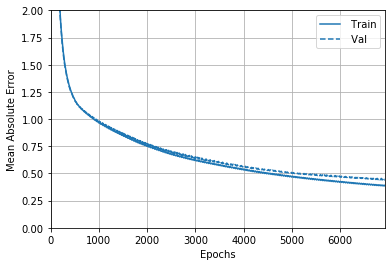

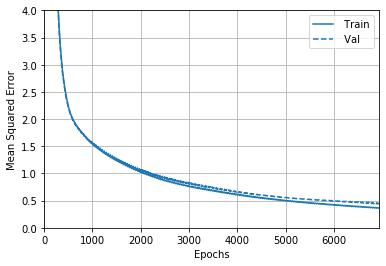

In [47]:
plt.figure()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({"": history}, metric = "mae")
plt.ylim([0, 2])
plt.ylabel('Mean Absolute Error')

plt.figure()
plotter.plot({"": history}, metric = "mse")
plt.ylim([0, 4])
plt.ylabel('Mean Squared Error')

plt.show()

In [48]:
def average_distance_error(preds, y_test):
    return np.mean(np.sqrt(np.sum(np.square(preds - y_test), axis=2)))

328/1 - 0s - loss: 0.4728 - mae: 0.4525 - mse: 0.4622
Test loss: 0.46224961484350807
Mean absolute error: 0.45245403
Mean squared error: 0.4622496
Average distance error: 0.7346980496434841


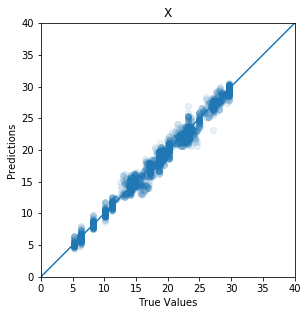

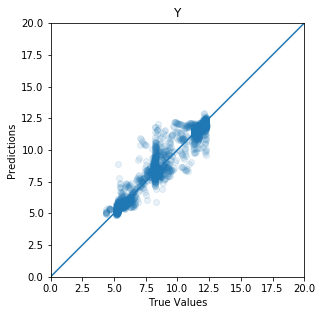

In [49]:
validation_scores = model.evaluate(X_validation, y_validation, verbose=2)
print("Test loss:", validation_scores[0])
print("Mean absolute error:", validation_scores[1])
print("Mean squared error:", validation_scores[2])

preds = model.predict(X_validation)
print("Average distance error:", average_distance_error(preds, y_validation))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, :, 0], preds[:, :, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')

ax1.scatter(y_validation[:, :, 1], preds[:, :, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

550/1 - 0s - loss: 1.6388 - mae: 1.0445 - mse: 1.9342
Test loss: 1.9341710320386019
Mean absolute error: 1.0445255
Mean squared error: 1.9341713
Average distance error: 1.6761913175040835


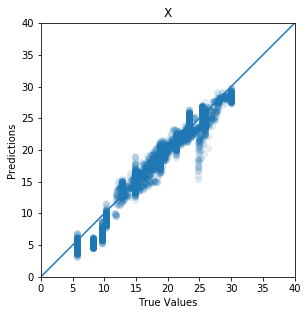

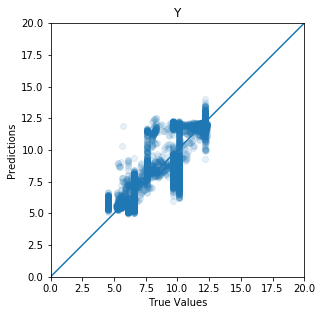

In [50]:
test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Mean absolute error:", test_scores[1])
print("Mean squared error:", test_scores[2])

preds = model.predict(X_test)
print("Average distance error:", average_distance_error(preds, y_test))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_test[:, :, 0], preds[:, :, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')

ax1.scatter(y_test[:, :, 1], preds[:, :, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

In [51]:
def cdf(preds, y_test):
    plt.figure(figsize=(10, 10))

    Z = np.sqrt(np.sum(np.square(preds - y_test), axis=2)).reshape(-1)
    N = Z.size

    X = np.sort(Z)
    F = np.array(range(N)) / float(N)
    plt.plot(X, F)
    plt.title('CDF of Euclidean Distance Error')
    plt.xlabel('Euclidean Distance Error (m)')
    plt.ylabel('Density')
    plt.show()

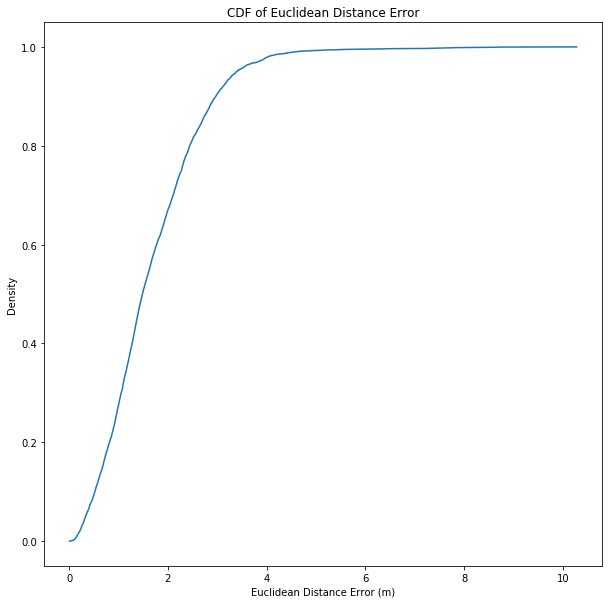

In [52]:
cdf(preds, y_test)

model.save('../Models/LSTM_Stationary_W10.h5')

model.save_weights('../Models/LSTM_Stationary_W10_weights.h5')